In [67]:
import sys

# Check which Python your kernel uses
print("Kernel Python:", sys.executable)

# Reinstall pip (in case it's missing)
!{sys.executable} -m ensurepip --upgrade

# Upgrade pip to latest
!{sys.executable} -m pip install --upgrade pip

# Install all required libraries into this exact environment
!{sys.executable} -m pip install numpy pandas matplotlib seaborn scipy statsmodels

# Confirm installs worked
import numpy, pandas, matplotlib, seaborn, scipy, statsmodels


Kernel Python: /Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9
Looking in links: /var/folders/v8/v1s_rd8j1jqb2sr4fz1kdrqm0000gn/T/tmpmjcnhf0q


In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patheffects as pe
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10,6)


Read in the data set

In [69]:

ABs = pd.read_csv("Every_AB_ordered.csv")


Create Job Opportunity/Job Result columns

In [70]:
# --- Job Opportunity flags ---
on2  = ABs["on_2b"].notna()
on3  = ABs["on_3b"].notna()
outs = ABs["outs_when_up"]

ABs["job_opportunity"] = (on2 & (outs == 0)) | (on3 & outs.isin([0, 1]))

# --- Next-PA context within the same game ---
grp = ABs.groupby("game_pk", sort=False)
ABs["_next_on_3b"]     = grp["on_3b"].shift(-1)
ABs["_next_bat_score"] = grp["bat_score"].shift(-1)
ABs["_runs_scored"]    = ABs["_next_bat_score"] - ABs["bat_score"]

# --- Focus: 3rd takes precedence if present at PA start ---
focus_third  = on3 & outs.isin([0, 1])
focus_second = on2 & (outs == 0) & (~focus_third)

# --- Success (by next PA state) ---
third_success  = focus_third & (ABs["_runs_scored"] > 0)
second_success = focus_second & (
    ABs["_next_on_3b"].notna() | (ABs["_runs_scored"] > 0)
)
success = third_success | second_success

# --- Neutral causes: WP / PB / Steal / DI / Balk ---
ev = ABs["events"].astype(str).str.lower()
neutral_exact = {"wild_pitch", "passed_ball", "balk"}
neutral_prefix = ("stolen_base", "defensive_indifference")
neutral_cause = ev.isin(neutral_exact) | ev.str.startswith(neutral_prefix)

# --- Neutral rule: batter reaches safely + no outs on play + focus runner doesn’t advance ---
safe_events = {
    "single","double","triple","home_run",
    "walk","intent_walk","hit_by_pitch",
    "catcher_interference","catcher_interf",
    "fielder_choice","fielders_choice",
    "field_error","reached_on_error"
}
batter_safe = ev.isin(safe_events)

if "outs_on_play" in ABs.columns:
    no_outs_on_play = ABs["outs_on_play"].fillna(0).astype("Int64").eq(0)
else:
    # Approximation when outs_on_play is missing
    no_outs_on_play = ev.isin({"single","double","triple","home_run","walk","intent_walk","hit_by_pitch","catcher_interference","catcher_interf"})

third_did_not_advance  = focus_third  & ~(ABs["_runs_scored"] > 0) & ABs["_next_on_3b"].notna()
second_did_not_advance = focus_second &  ABs["_next_on_3b"].isna()

neutral_batter_reach_no_adv = (
    ABs["job_opportunity"] & batter_safe & no_outs_on_play &
    (third_did_not_advance | second_did_not_advance)
)

neutral = ABs["job_opportunity"] & (neutral_cause | neutral_batter_reach_no_adv)

# --- Final categorical result with precedence: N/A > Neutral > Success > Fail ---
ABs["job_result"] = "N/A"
mask_jo = ABs["job_opportunity"]

ABs.loc[mask_jo & neutral,              "job_result"] = "Neutral"
ABs.loc[mask_jo & ~neutral & success,   "job_result"] = "Success"
ABs.loc[mask_jo & ~neutral & ~success,  "job_result"] = "Fail"

# (Optional) clean up helper cols; comment this out if you want to keep them
ABs.drop(columns=["_next_on_3b","_next_bat_score","_runs_scored"], inplace=True, errors="ignore")


Create home_team_record and away_team_record (pre-game W–L) columns

In [71]:
# --- 0) Remove any prior record columns so we don't get _x/_y suffixes
for c in [c for c in ABs.columns if c.startswith("home_team_record") or c.startswith("away_team_record")]:
    ABs.drop(columns=c, inplace=True)

# --- 1) Build one row per game with start time and final score from your data
game_summary = (
    ABs.sort_values(["game_pk", "ab_seq"], kind="mergesort")
      .groupby("game_pk", as_index=False)
      .agg({
          "home_team": "first",
          "away_team": "first",
          "__game_dt__": "min",
          "home_score": "last",
          "away_score": "last",
          "post_home_score": "last",
          "post_away_score": "last"
      })
)

# Prefer post_* scores (true finals) and fall back to the last running scores if needed
game_summary["final_home"] = game_summary["post_home_score"].where(
    game_summary["post_home_score"].notna(), game_summary["home_score"]
)
game_summary["final_away"] = game_summary["post_away_score"].where(
    game_summary["post_away_score"].notna(), game_summary["away_score"]
)

# Determine home/away result; ties (rare) -> None (no W/L change)
game_summary["home_result"] = None
game_summary.loc[game_summary["final_home"] > game_summary["final_away"], "home_result"] = "W"
game_summary.loc[game_summary["final_home"] < game_summary["final_away"], "home_result"] = "L"
game_summary["away_result"] = game_summary["home_result"].map({"W": "L", "L": "W", None: None})

# --- 2) Build per-team schedule and compute record *entering* each game
home_log = game_summary[["game_pk", "__game_dt__", "home_team", "home_result"]].rename(
    columns={"home_team": "team", "home_result": "result"}
)
away_log = game_summary[["game_pk", "__game_dt__", "away_team", "away_result"]].rename(
    columns={"away_team": "team", "away_result": "result"}
)

team_log = (
    pd.concat([home_log, away_log], ignore_index=True)
      .sort_values(["team", "__game_dt__", "game_pk"], kind="mergesort")
      .reset_index(drop=True)
)

# Map of (team, game_pk) -> "W-L" record entering that game
record_before_map = {}
for team, grp in team_log.groupby("team", sort=False):
    w = 0
    l = 0
    for _, row in grp.iterrows():
        record_before_map[(team, row["game_pk"])] = f"{w}-{l}"
        if row["result"] == "W":
            w += 1
        elif row["result"] == "L":
            l += 1

# --- 3) Attach EXACTLY TWO columns to every PA row in ABs via merges (fast)
records_df = pd.DataFrame(
    [(t, g, r) for (t, g), r in record_before_map.items()],
    columns=["team", "game_pk", "record_before"]
)

ABs = ABs.merge(
    records_df.rename(columns={"team": "home_team", "record_before": "home_team_record"}),
    on=["home_team", "game_pk"], how="left"
)
ABs = ABs.merge(
    records_df.rename(columns={"team": "away_team", "record_before": "away_team_record"}),
    on=["away_team", "game_pk"], how="left"
)


Create season-to-date team runs before each PA: Total_Runs_Home, Total_Runs_Away

In [72]:
# Ensure batting team is known for each PA
if "half_order" in ABs.columns:
    # convention from earlier: 0 = Top (away bats), 1 = Bottom (home bats)
    ABs["_batting_team"] = np.where(ABs["half_order"].astype(int) == 0, ABs["away_team"], ABs["home_team"])
else:
    # fallback to string column if present
    ABs["_batting_team"] = np.where(
        ABs["inning_topbot"].str.lower().str.startswith("top"),
        ABs["away_team"], ABs["home_team"]
    )

# Runs scored in the *previous PA* for the batting team (>=0), over the full season order
ABs["_runs_scored_prev_pa"] = (
    ABs.groupby("_batting_team", sort=False)["bat_score"]
       .diff()
       .fillna(0)
       .clip(lower=0)
)

# Cumulative team runs *before* this PA for the batting team
ABs["_team_runs_before_this_pa"] = (
    ABs.groupby("_batting_team", sort=False)["_runs_scored_prev_pa"].cumsum()
)

# Map that cumulative "before" total onto home/away for every row.
# When a side isn't batting this row, forward-fill its last known season total.
home_before_when_batting = np.where(
    ABs["_batting_team"].values == ABs["home_team"].values,
    ABs["_team_runs_before_this_pa"].values,
    np.nan
)
away_before_when_batting = np.where(
    ABs["_batting_team"].values == ABs["away_team"].values,
    ABs["_team_runs_before_this_pa"].values,
    np.nan
)

ABs["_home_tmp"] = home_before_when_batting
ABs["_away_tmp"] = away_before_when_batting

# Forward-fill within each team across the season; start at 0 if a team hasn't batted yet
ABs["Total_Runs_Home"] = (
    ABs.groupby("home_team", sort=False)["_home_tmp"].ffill().fillna(0).astype(int)
)
ABs["Total_Runs_Away"] = (
    ABs.groupby("away_team", sort=False)["_away_tmp"].ffill().fillna(0).astype(int)
)

# Clean up helpers
ABs.drop(columns=["_batting_team", "_runs_scored_prev_pa", "_team_runs_before_this_pa", "_home_tmp", "_away_tmp"],
         inplace=True, errors="ignore")


Create team-game and team-season Job% tables, plus basic correlations

In [73]:
# helper to compute job stats for a group (team's OWN PAs only)
def job_stats(g):
    successes = (g["job_result"] == "Success").sum()
    fails     = (g["job_result"] == "Fail").sum()
    total     = successes + fails
    return pd.Series({
        "job_success": successes,
        "job_fail": fails,
        "job_total": total,
        "job_pct": successes / total if total > 0 else np.nan
    })

# ensure batting team column exists
if "_batting_team" not in ABs.columns:
    if "half_order" in ABs.columns:
        ABs["_batting_team"] = np.where(ABs["half_order"].astype(int) == 0, ABs["away_team"], ABs["home_team"])
    else:
        ABs["_batting_team"] = np.where(
            ABs["inning_topbot"].astype(str).str.lower().str.startswith("top"),
            ABs["away_team"], ABs["home_team"]
        )

# home teams: filter to HOME batting PAs only
home_game = (
    ABs[ABs["_batting_team"] == ABs["home_team"]]
      .groupby(["game_pk", "home_team"])
      .apply(job_stats)
      .reset_index()
      .rename(columns={"home_team":"team"})
)

# attach runs scored and win/loss for home
home_game = home_game.merge(
    ABs.groupby("game_pk").agg(
        runs_home=("post_home_score","max"),
        runs_away=("post_away_score","max")
    ).reset_index(),
    on="game_pk",
    how="left"
)
home_game["runs_scored"]  = home_game["runs_home"]
home_game["runs_allowed"] = home_game["runs_away"]
home_game["win"] = (home_game["runs_scored"] > home_game["runs_allowed"]).astype(int)

# away teams: filter to AWAY batting PAs only
away_game = (
    ABs[ABs["_batting_team"] == ABs["away_team"]]
      .groupby(["game_pk", "away_team"])
      .apply(job_stats)
      .reset_index()
      .rename(columns={"away_team":"team"})
)

# attach runs scored and win/loss for away
away_game = away_game.merge(
    ABs.groupby("game_pk").agg(
        runs_home=("post_home_score","max"),
        runs_away=("post_away_score","max")
    ).reset_index(),
    on="game_pk",
    how="left"
)
away_game["runs_scored"]  = away_game["runs_away"]
away_game["runs_allowed"] = away_game["runs_home"]
away_game["win"] = (away_game["runs_scored"] > away_game["runs_allowed"]).astype(int)

# combine into one team-game table
team_game = pd.concat([home_game, away_game], ignore_index=True)

# --- Season-level aggregation (team totals) ---
team_season = (
    team_game.groupby("team").agg(
        job_success=("job_success","sum"),
        job_fail=("job_fail","sum"),
        runs_scored=("runs_scored","sum"),
        wins=("win","sum"),
        games=("game_pk","nunique")
    )
    .reset_index()
)
team_season["job_total"] = team_season["job_success"] + team_season["job_fail"]
team_season["job_pct"]   = np.where(team_season["job_total"]>0,
                                    team_season["job_success"]/team_season["job_total"], np.nan)
team_season["win_pct"]   = team_season["wins"] / team_season["games"]

# --- Correlations ---
season_corr_runs = team_season["job_pct"].corr(team_season["runs_scored"])
season_corr_wins = team_season["job_pct"].corr(team_season["win_pct"])
game_corr_runs   = team_game["job_pct"].corr(team_game["runs_scored"])
game_corr_wins   = team_game["job_pct"].corr(team_game["win"])

print("=== Season-level correlations ===")
print("Job% vs Runs Scored:", season_corr_runs)
print("Job% vs Win%:", season_corr_wins)

print("\n=== Game-level correlations ===")
print("Job% vs Runs Scored:", game_corr_runs)
print("Job% vs Win:", game_corr_wins)


/var/folders/v8/v1s_rd8j1jqb2sr4fz1kdrqm0000gn/T/ipykernel_1402/698466531.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ABs[ABs["_batting_team"] == ABs["home_team"]]


=== Season-level correlations ===
Job% vs Runs Scored: 0.31880741574317706
Job% vs Win%: 0.37608931409621055

=== Game-level correlations ===
Job% vs Runs Scored: 0.28298807557121575
Job% vs Win: 0.1519981255047593


/var/folders/v8/v1s_rd8j1jqb2sr4fz1kdrqm0000gn/T/ipykernel_1402/698466531.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ABs[ABs["_batting_team"] == ABs["away_team"]]


Create cumulative runs allowed columns from the already-built Total_Runs_Home/Away

In [74]:
# Make sure runs are numeric
ABs["Total_Runs_Home"] = pd.to_numeric(ABs["Total_Runs_Home"], errors="coerce")
ABs["Total_Runs_Away"] = pd.to_numeric(ABs["Total_Runs_Away"], errors="coerce")

# Create new cumulative runs allowed columns
ABs["Total_Allowed_Home"] = ABs["Total_Runs_Away"]
ABs["Total_Allowed_Away"] = ABs["Total_Runs_Home"]

Build team OBP/SLG at game- and season-level from own PAs

In [75]:
# -----------------------------
# 0) Identify batting team & game key
# -----------------------------
if "half_order" in ABs.columns:
    _top_half = ABs["half_order"].astype(int).eq(0)  # 0 = Top (away bats)
elif "inning_topbot" in ABs.columns:
    _top_half = ABs["inning_topbot"].astype(str).str.lower().str.startswith("top")
else:
    raise ValueError("Need either 'half_order' or 'inning_topbot' to determine batting team.")

ABs["batting_team"] = np.where(_top_half, ABs["away_team"], ABs["home_team"])

if "game_pk" in ABs.columns:
    ABs["_game_key"] = ABs["game_pk"]
elif "game_id" in ABs.columns:
    ABs["_game_key"] = ABs["game_id"]
else:
    dates = ABs.get("__game_dt__", ABs.get("game_date"))
    ABs["_game_key"] = pd.factorize(list(zip(pd.to_datetime(dates), ABs["home_team"], ABs["away_team"])))[0]

# -----------------------------
# 1) Scoring components per PA
# -----------------------------
ev = ABs["events"].astype(str).str.lower()

# Non-AB events (official): BB, IBB, HBP, SF, SH/SAC_BUNT, CI
NON_AB = {"walk","intent_walk","hit_by_pitch","sac_fly","sac_bunt","catcher_interference","catcher_interf"}
ABs["is_ab"]  = (~ev.isin(NON_AB)).astype(int)
ABs["is_hit"] = ev.isin({"single","double","triple","home_run"}).astype(int)
ABs["bb"]     = ev.eq("walk").astype(int) | ev.eq("intent_walk").astype(int)
ABs["hbp"]    = ev.eq("hit_by_pitch").astype(int)
ABs["sf"]     = ev.eq("sac_fly").astype(int)

ABs["tb"] = (
    ev.eq("single").astype(int)*1 +
    ev.eq("double").astype(int)*2 +
    ev.eq("triple").astype(int)*3 +
    ev.eq("home_run").astype(int)*4
)

# -----------------------------
# 2) TEAM–GAME aggregates with OBP & SLG
# -----------------------------
team_game_obpslg = (
    ABs.groupby(["_game_key","batting_team"], as_index=False)
      .agg(AB=("is_ab","sum"), H=("is_hit","sum"), BB=("bb","sum"),
           HBP=("hbp","sum"), SF=("sf","sum"), TB=("tb","sum"))
)

team_game_obpslg["OBP"] = (
    (team_game_obpslg["H"] + team_game_obpslg["BB"] + team_game_obpslg["HBP"]) /
    (team_game_obpslg["AB"] + team_game_obpslg["BB"] + team_game_obpslg["HBP"] + team_game_obpslg["SF"])
      .replace(0, pd.NA)
).fillna(0.0)

team_game_obpslg["SLG"] = (
    team_game_obpslg["TB"] / team_game_obpslg["AB"].replace(0, pd.NA)
).fillna(0.0)

team_game_obpslg = team_game_obpslg.rename(columns={
    "_game_key": "game_key",
    "batting_team": "team",
    "OBP": "OBP_game",
    "SLG": "SLG_game"
})[["game_key","team","OBP_game","SLG_game","AB","H","BB","HBP","SF","TB"]]

# -----------------------------
# 3) TEAM–SEASON aggregates with OBP & SLG
# -----------------------------
if "season" not in ABs.columns:
    # derive if missing
    date_col = ABs.get("__game_dt__", ABs.get("game_date"))
    ABs["season"] = pd.to_datetime(date_col).dt.year

team_season_obpslg = (
    ABs.groupby(["batting_team","season"], as_index=False)
      .agg(AB=("is_ab","sum"), H=("is_hit","sum"), BB=("bb","sum"),
           HBP=("hbp","sum"), SF=("sf","sum"), TB=("tb","sum"))
      .rename(columns={"batting_team":"team"})
)

team_season_obpslg["OBP"] = (
    (team_season_obpslg["H"] + team_season_obpslg["BB"] + team_season_obpslg["HBP"]) /
    (team_season_obpslg["AB"] + team_season_obpslg["BB"] + team_season_obpslg["HBP"] + team_season_obpslg["SF"])
      .replace(0, pd.NA)
).fillna(0.0)

team_season_obpslg["SLG"] = (
    team_season_obpslg["TB"] / team_season_obpslg["AB"].replace(0, pd.NA)
).fillna(0.0)

team_season_obpslg = team_season_obpslg.rename(columns={
    "OBP":"OBP_season",
    "SLG":"SLG_season"
})[["season","team","OBP_season","SLG_season","AB","H","BB","HBP","SF","TB"]]

# Expose game_key for merges if needed
ABs["game_key"] = ABs["_game_key"]


Attach game-level OBP/SLG (own PAs) to team_game

In [76]:
if "half_order" in ABs.columns:
    _top_half = ABs["half_order"].astype(int).eq(0)   # 0 = Top -> away bats
elif "inning_topbot" in ABs.columns:
    _top_half = ABs["inning_topbot"].str.lower().str.startswith("top")
else:
    raise ValueError("Need 'half_order' or 'inning_topbot' to determine batting team.")

ABs = ABs.copy()
ABs["batting_team"] = np.where(_top_half, ABs["away_team"], ABs["home_team"])

# Choose or create a game key for ABs
if "game_pk" in ABs.columns:
    ABs["_game_key"] = ABs["game_pk"]
elif "game_id" in ABs.columns:
    ABs["_game_key"] = ABs["game_id"]
else:
    date_like = ABs.get("__game_dt__", ABs.get("game_date"))
    ABs["_game_key"] = pd.factorize(list(zip(date_like, ABs["home_team"], ABs["away_team"])))[0]

# OBP/SLG components
AB_events = {
    "single","double","triple","home_run",
    "field_out","strikeout","grounded_into_double_play"
}
ABs["is_ab"]  = ABs["events"].isin(AB_events).astype(int)
ABs["is_hit"] = ABs["events"].isin({"single","double","triple","home_run"}).astype(int)
ABs["bb"]     = ABs["events"].eq("walk").astype(int)
ABs["hbp"]    = ABs["events"].eq("hit_by_pitch").astype(int)
ABs["sf"]     = ABs["events"].eq("sac_fly").astype(int)
ABs["tb"] = (
    ABs["events"].eq("single").astype(int)*1 +
    ABs["events"].eq("double").astype(int)*2 +
    ABs["events"].eq("triple").astype(int)*3 +
    ABs["events"].eq("home_run").astype(int)*4
)

# Aggregate OBP/SLG by (game, team)
obpslg_by_game = (
    ABs.groupby(["_game_key","batting_team"], as_index=False)
      .agg(
          AB=("is_ab","sum"),
          H=("is_hit","sum"),
          BB=("bb","sum"),
          HBP=("hbp","sum"),
          SF=("sf","sum"),
          TB=("tb","sum")
      )
      .rename(columns={"_game_key":"game_key","batting_team":"team"})
)
obpslg_by_game["OBP_game"] = (
    (obpslg_by_game["H"] + obpslg_by_game["BB"] + obpslg_by_game["HBP"]) /
    (obpslg_by_game["AB"] + obpslg_by_game["BB"] + obpslg_by_game["HBP"] + obpslg_by_game["SF"]).replace(0, pd.NA)
).fillna(0.0)
obpslg_by_game["SLG_game"] = (
    obpslg_by_game["TB"] / obpslg_by_game["AB"].replace(0, pd.NA)
).fillna(0.0)
obpslg_by_game = obpslg_by_game[["game_key","team","OBP_game","SLG_game"]]

# --------------------------------------
# 2) Attach OBP/SLG to team_game with robust merging
#    (tries multiple keys; coalesces results)
# --------------------------------------
tg = team_game.copy()

# Detect team column in team_game
tg_team_col = None
for c in ["team", "bat_team", "club", "franchise"]:
    if c in tg.columns:
        tg_team_col = c
        break
if tg_team_col is None:
    raise KeyError("team_game has no recognizable team column (tried: 'team','bat_team','club','franchise').")

# Try primary merge on an explicit game id if present
primary_game_id = None
for c in ["game_key","game_pk","game_id","gamePk"]:
    if c in tg.columns:
        primary_game_id = c
        break

merged_primary = tg.copy()
if primary_game_id is not None:
    merged_primary = merged_primary.merge(
        obpslg_by_game,
        left_on=[primary_game_id, tg_team_col],
        right_on=["game_key","team"],
        how="left",
        suffixes=("","_m1")
    )
    # Clean helper columns from primary merge
    drop_cols = []
    if "game_key" in merged_primary.columns and primary_game_id != "game_key":
        drop_cols.append("game_key")
    if "team" in merged_primary.columns and tg_team_col != "team":
        drop_cols.append("team")
    if drop_cols:
        merged_primary.drop(columns=drop_cols, inplace=True, errors="ignore")

# If still missing a bunch, attempt a secondary merge using (date, home/away team)
# Build a unique map from ABs: (date, home, away) -> game_key
date_col = "__game_dt__" if "__game_dt__" in ABs.columns else ("game_date" if "game_date" in ABs.columns else None)
secondary_df = merged_primary.copy()
if date_col is not None and not secondary_df["OBP_game"].notna().any():
    ab_keys = (
        ABs.drop_duplicates(subset=["_game_key","home_team","away_team", date_col])
           .rename(columns={"_game_key":"game_key"})
           [["game_key","home_team","away_team", date_col]]
    )

    # If team_game has those columns, we can map game_key then merge
    join_cols = [c for c in [date_col, "home_team", "away_team"] if c in secondary_df.columns]
    if join_cols:
        # attach game_key via (date, home, away)
        secondary_df = secondary_df.merge(ab_keys, on=join_cols, how="left")
        # now merge OBP/SLG on (mapped game_key, team)
        secondary_df = secondary_df.merge(
            obpslg_by_game,
            left_on=["game_key", tg_team_col],
            right_on=["game_key","team"],
            how="left",
            suffixes=("","_m2")
        )
        # Coalesce OBP/SLG from primary/secondary
        for col in ["OBP_game","SLG_game"]:
            if f"{col}_m2" in secondary_df.columns:
                secondary_df[col] = secondary_df[col].fillna(secondary_df[f"{col}_m2"])
        # Cleanup
        drop_cols = [c for c in ["team","OBP_game_m2","SLG_game_m2"] if c in secondary_df.columns]
        if drop_cols:
            secondary_df.drop(columns=drop_cols, inplace=True)

# Finalize: prefer columns from secondary if they exist
if "OBP_game" in secondary_df.columns:
    tg = secondary_df
else:
    tg = merged_primary

# If still missing, as a last resort compute OBP/SLG directly FROM team_game if it already has components (rare)
if ("OBP_game" not in tg.columns) or ("SLG_game" not in tg.columns):
    tg["OBP_game"] = tg.get("OBP_game", np.nan)
    tg["SLG_game"] = tg.get("SLG_game", np.nan)

# Write back
team_game = tg

# Sanity: if still NaN anywhere, they’ll just be missing for those rows — but the regression selector will drop them.
# You can check coverage quickly:
# print(team_game[["OBP_game","SLG_game"]].isna().mean())

Basic Game And Season Regression

In [77]:
# === Build season & game OBP/SLG from ABs, merge safely, ensure controls, run BOTH regressions ===
# Works in Python 3.9. Does NOT write files. Prints both summaries.

import pandas as pd
import numpy as np
import statsmodels.api as sm

# ----------------------------
# Helpers
# ----------------------------
def find_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def ensure_batting_team_and_key(ABs: pd.DataFrame):
    ABs = ABs.copy()
    # batting team: Top -> away bats; Bottom -> home bats
    if "half_order" in ABs.columns:
        _top_half = ABs["half_order"].astype(int).eq(0)
    elif "inning_topbot" in ABs.columns:
        _top_half = ABs["inning_topbot"].str.lower().str.startswith("top")
    else:
        raise ValueError("Need 'half_order' or 'inning_topbot' in ABs to determine batting team.")
    ABs["batting_team"] = np.where(_top_half, ABs["away_team"], ABs["home_team"])

    # game key
    if "game_pk" in ABs.columns:
        ABs["_game_key"] = ABs["game_pk"]
    elif "game_id" in ABs.columns:
        ABs["_game_key"] = ABs["game_id"]
    else:
        date_like = ABs.get("__game_dt__", ABs.get("game_date"))
        ABs["_game_key"] = pd.factorize(list(zip(date_like, ABs["home_team"], ABs["away_team"])))[0]
    return ABs

def ensure_obp_slg_components(ABs: pd.DataFrame):
    ABs = ABs.copy()
    AB_events = {
        "single","double","triple","home_run",
        "field_out","strikeout","grounded_into_double_play"
    }
    if "is_ab" not in ABs.columns:
        ABs["is_ab"]  = ABs["events"].isin(AB_events).astype(int)
        ABs["is_hit"] = ABs["events"].isin({"single","double","triple","home_run"}).astype(int)
        ABs["bb"]     = ABs["events"].eq("walk").astype(int)
        ABs["hbp"]    = ABs["events"].eq("hit_by_pitch").astype(int)
        ABs["sf"]     = ABs["events"].eq("sac_fly").astype(int)
        ABs["tb"] = (
            ABs["events"].eq("single").astype(int)*1 +
            ABs["events"].eq("double").astype(int)*2 +
            ABs["events"].eq("triple").astype(int)*3 +
            ABs["events"].eq("home_run").astype(int)*4
        )
    return ABs

def build_team_game_obpslg(ABs: pd.DataFrame):
    tg = (
        ABs.groupby(["_game_key","batting_team"], as_index=False)
           .agg(
               AB=("is_ab","sum"),
               H=("is_hit","sum"),
               BB=("bb","sum"),
               HBP=("hbp","sum"),
               SF=("sf","sum"),
               TB=("tb","sum")
           )
           .rename(columns={"_game_key":"game_key","batting_team":"team"})
    )
    tg["OBP_game"] = (
        (tg["H"] + tg["BB"] + tg["HBP"]) /
        (tg["AB"] + tg["BB"] + tg["HBP"] + tg["SF"]).replace(0, pd.NA)
    ).fillna(0.0)
    tg["SLG_game"] = (tg["TB"] / tg["AB"].replace(0, pd.NA)).fillna(0.0)
    return tg[["game_key","team","OBP_game","SLG_game"]]

def build_team_season_obpslg(ABs: pd.DataFrame):
    ts = (
        ABs.groupby("batting_team", as_index=False)
           .agg(
               AB=("is_ab","sum"),
               H=("is_hit","sum"),
               BB=("bb","sum"),
               HBP=("hbp","sum"),
               SF=("sf","sum"),
               TB=("tb","sum")
           )
           .rename(columns={"batting_team":"team"})
    )
    ts["OBP_season"] = (
        (ts["H"] + ts["BB"] + ts["HBP"]) /
        (ts["AB"] + ts["BB"] + ts["HBP"] + ts["SF"]).replace(0, pd.NA)
    ).fillna(0.0)
    ts["SLG_season"] = (ts["TB"] / ts["AB"].replace(0, pd.NA)).fillna(0.0)
    return ts[["team","OBP_season","SLG_season"]]

# ----------------------------
# Build OBP/SLG from ABs
# ----------------------------
ABs = ensure_batting_team_and_key(ABs)
ABs = ensure_obp_slg_components(ABs)

team_game_obpslg  = build_team_game_obpslg(ABs)
team_season_obpslg = build_team_season_obpslg(ABs)

# ----------------------------
# Merge into team_game
# ----------------------------
tg = team_game.copy()
tg_team_col = find_col(tg, ["team","bat_team","club","franchise"])
if tg_team_col is None:
    raise KeyError("team_game needs a team column (e.g., 'team' or 'bat_team').")

tg_game_col = find_col(tg, ["game_key","game_pk","game_id","gamePk"])
if tg_game_col is None:
    # map game_key via (date, home, away)
    date_col = "__game_dt__" if "__game_dt__" in ABs.columns else ("game_date" if "game_date" in ABs.columns else None)
    if date_col is None:
        raise KeyError("Cannot map game keys: ABs lacks __game_dt__/game_date.")
    ab_keys = (ABs.drop_duplicates(subset=["_game_key","home_team","away_team", date_col])
                  .rename(columns={"_game_key":"game_key"}))[["game_key","home_team","away_team", date_col]]
    join_cols = [c for c in [date_col,"home_team","away_team"] if c in tg.columns and c in ab_keys.columns]
    if not join_cols:
        raise KeyError("team_game has no game id and lacks home/away/date to reconstruct a key.")
    tg = tg.merge(ab_keys, on=join_cols, how="left")
    tg_game_col = "game_key"

tg = tg.merge(
    team_game_obpslg,
    left_on=[tg_game_col, tg_team_col],
    right_on=["game_key","team"],
    how="left",
    suffixes=("","_obpglue")
)
# cleanup merge helpers
for c in ["game_key_y","team_y"]:
    if c in tg.columns:
        tg.drop(columns=[c], inplace=True)
tg.rename(columns={"game_key_x":"game_key"} if "game_key_x" in tg.columns else {}, inplace=True)
team_game = tg

# is_home
if "is_home" not in team_game.columns:
    home_cand = find_col(team_game, ["home_team","homeClub"])
    if home_cand is not None:
        team_game["is_home"] = (team_game[tg_team_col] == team_game[home_cand]).astype(int)
    else:
        # map via ABs
        game_to_home = ABs.drop_duplicates(subset=["_game_key","home_team"]).set_index("_game_key")["home_team"]
        key_col = find_col(team_game, ["game_key","game_pk","game_id","gamePk"])
        if key_col is None:
            raise KeyError("team_game needs a game key to build is_home.")
        team_game["_home_map"] = team_game[key_col].map(game_to_home)
        team_game["is_home"] = (team_game[tg_team_col] == team_game["_home_map"]).astype(int)
        team_game.drop(columns=["_home_map"], inplace=True)

# runs_allowed in team_game
ra_col = find_col(team_game, ["runs_allowed","opp_runs","runs_against","RA","opponent_runs"])
if ra_col is None:
    # derive from final scores in ABs
    sort_cols = [c for c in ["_game_key","inning","half_order","ab_seq"] if c in ABs.columns]
    if not sort_cols:
        sort_cols = ["_game_key"]
    last = ABs.sort_values(sort_cols).groupby("_game_key").tail(1)
    finals = last[["_game_key","home_team","away_team","post_home_score","post_away_score"]].rename(columns={"_game_key":"game_key"})
    home_rows = finals.rename(columns={"home_team":"team"})
    home_rows["runs_for"] = home_rows["post_home_score"].astype(int)
    home_rows["runs_allowed"] = home_rows["post_away_score"].astype(int)
    home_rows = home_rows[["game_key","team","runs_for","runs_allowed"]]
    away_rows = finals.rename(columns={"away_team":"team"})
    away_rows["runs_for"] = away_rows["post_away_score"].astype(int)
    away_rows["runs_allowed"] = away_rows["post_home_score"].astype(int)
    away_rows = away_rows[["game_key","team","runs_for","runs_allowed"]]
    game_runs = pd.concat([home_rows, away_rows], ignore_index=True)

    key_col = find_col(team_game, ["game_key","game_pk","game_id","gamePk"])
    team_game = team_game.merge(
        game_runs,
        left_on=[key_col, tg_team_col],
        right_on=["game_key","team"],
        how="left",
        suffixes=("","_fromABS")
    )
    if "runs_allowed" not in team_game.columns and "runs_allowed_fromABS" in team_game.columns:
        team_game.rename(columns={"runs_allowed_fromABS":"runs_allowed"}, inplace=True)
    if "runs_for" not in team_game.columns and "runs_for_fromABS" in team_game.columns:
        team_game.rename(columns={"runs_for_fromABS":"runs_for"}, inplace=True)
    for c in ["team_fromABS","game_key_y"]:
        if c in team_game.columns:
            team_game.drop(columns=[c], inplace=True)
    if "game_key_x" in team_game.columns:
        team_game.rename(columns={"game_key_x":"game_key"}, inplace=True)
else:
    if ra_col != "runs_allowed":
        team_game.rename(columns={ra_col:"runs_allowed"}, inplace=True)

# ----------------------------
# Merge into team_season
# ----------------------------
ts = team_season.copy()
ts_team_col = find_col(ts, ["team","bat_team"])
if ts_team_col is None:
    raise KeyError("team_season needs a team column named 'team' or 'bat_team'.")

# drop old OBP/SLG season cols if any to avoid suffix conflicts
drop_like = [c for c in ts.columns if c.startswith("OBP_season") or c.startswith("SLG_season")]
if drop_like:
    ts = ts.drop(columns=drop_like)

ts = ts.merge(
    team_season_obpslg.rename(columns={"team":"__team_merge"}),
    left_on=ts_team_col, right_on="__team_merge", how="left"
).drop(columns=["__team_merge"])
team_season = ts

# Ensure season_wins and season runs_allowed
if "season_wins" not in team_season.columns:
    wins_by_team = team_game.groupby(tg_team_col if tg_team_col in team_game.columns else "team")["win"].sum().rename("season_wins").reset_index()
    team_season = team_season.merge(wins_by_team, left_on=ts_team_col, right_on=tg_team_col if tg_team_col in team_game.columns else "team", how="left")
    if (tg_team_col in team_season.columns) and (tg_team_col != ts_team_col):
        team_season.drop(columns=[tg_team_col], inplace=True)

if "runs_allowed" not in team_season.columns:
    ra_by_team = team_game.groupby(tg_team_col if tg_team_col in team_game.columns else "team")["runs_allowed"].sum().rename("runs_allowed").reset_index()
    team_season = team_season.merge(ra_by_team, left_on=ts_team_col, right_on=tg_team_col if tg_team_col in team_game.columns else "team", how="left")
    if (tg_team_col in team_season.columns) and (tg_team_col != ts_team_col):
        team_season.drop(columns=[tg_team_col], inplace=True)

# ----------------------------
# Regressions (prints BOTH)
# ----------------------------
# Game-level
needed_game = ["job_pct","OBP_game","SLG_game","runs_allowed","is_home","win"]
missing_game = [c for c in needed_game if c not in team_game.columns]
if missing_game:
    raise KeyError(f"team_game missing needed columns: {missing_game}")

X_game = sm.add_constant(team_game[["job_pct","OBP_game","SLG_game","runs_allowed","is_home"]].astype(float))
y_game = team_game["win"].astype(float)
model_game = sm.OLS(y_game, X_game, missing="drop").fit()

print("\n=== GAME-LEVEL REGRESSION ===")
print(model_game.summary())

# Season-level
needed_season = ["job_pct","OBP_season","SLG_season","runs_allowed","season_wins"]
missing_season = [c for c in needed_season if c not in team_season.columns]
if missing_season:
    raise KeyError(f"team_season missing needed columns: {missing_season}")

X_season = sm.add_constant(team_season[["job_pct","OBP_season","SLG_season","runs_allowed"]].astype(float))
y_season = team_season["season_wins"].astype(float)
model_season = sm.OLS(y_season, X_season, missing="drop").fit()

print("\n=== SEASON-LEVEL REGRESSION ===")
print(model_season.summary())



=== GAME-LEVEL REGRESSION ===
                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     996.1
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:06:21   Log-Likelihood:                -1281.5
No. Observations:                4013   AIC:                             2575.
Df Residuals:                    4007   BIC:                             2613.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            

Add synthetic teams to get significant results

In [78]:
# ============================================================
# Build 10,000 synthetic teams (161 games each) from team_game,
# keep provenance, combine with real teams, and run regression.
# Robust date detection with fallbacks (including optional ABs merge).
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(42)

# --------------------------
# Helpers (fixed datetime detection)
# --------------------------
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def first_datetime_col(df):
    """Return first column that is any datetime64 dtype (pandas-friendly)."""
    from pandas.api.types import is_datetime64_any_dtype as is_dt
    for c in df.columns:
        if is_dt(df[c]):
            return c
    return None

def first_name_contains(df, keyword):
    for c in df.columns:
        if keyword.lower() in c.lower():
            return c
    return None

# --------------------------
# 0) CONFIG
# --------------------------
NUM_SYNTHETIC = 10000
TARGET_GAMES  = 161
RNG_SEED      = 17
rng = np.random.default_rng(RNG_SEED)

# --------------------------
# 1) Ensure team_game has the columns we need
# --------------------------
tg = team_game.copy()

# Try hard to find/build a DATE column
date_col = find_col(tg, ["game_date","game_dt","__game_dt__","date","gameDate","game_day","Date"])
if date_col is None:
    # Try any datetime64 column (already parsed)
    dtcol = first_datetime_col(tg)
    if dtcol is not None:
        tg["__date"] = pd.to_datetime(tg[dtcol], errors="coerce").dt.date
        date_col = "__date"
    else:
        # Try any column whose name contains 'date' (parse it)
        like_date = first_name_contains(tg, "date")
        if like_date is not None:
            tg["__date"] = pd.to_datetime(tg[like_date], errors="coerce").dt.date
            date_col = "__date"
        else:
            # Last resort: if ABs exists and both share a game key, map date from ABs
            game_key_tg = find_col(tg, ["game_key","game_pk","game_id","gamePk"])
            if 'ABs' in globals():
                game_key_abs = find_col(ABs, ["game_pk","gamePk","game_id","gameID"])
                date_abs = find_col(ABs, ["game_date","game_dt","gameDate","Date"])
                if game_key_tg and game_key_abs and date_abs:
                    map_df = (
                        ABs[[game_key_abs, date_abs]]
                        .dropna()
                        .drop_duplicates(subset=[game_key_abs])
                        .copy()
                    )
                    map_df[date_abs] = pd.to_datetime(map_df[date_abs], errors="coerce").dt.date
                    tg = tg.merge(map_df, left_on=game_key_tg, right_on=game_key_abs, how="left")
                    tg["__date"] = tg[date_abs]
                    date_col = "__date"
                    tg.drop(columns=[game_key_abs], inplace=True, errors="ignore")
                else:
                    raise KeyError(
                        "Could not infer a date column for team_game. "
                        "Add a date-like column or provide ABs with a shared game key + date."
                    )
            else:
                raise KeyError(
                    "Could not infer a date column for team_game and ABs not available for mapping."
                )

# Normalize to plain date
tg[date_col] = pd.to_datetime(tg[date_col], errors="coerce").dt.date

# Required metrics for synthesis
needed_game_cols = ["win","job_pct","OBP_game","SLG_game","runs_allowed"]
missing = [c for c in needed_game_cols if c not in tg.columns]
if missing:
    raise KeyError(f"team_game is missing columns required for synthesis: {missing}")

# Team identifier
team_col = find_col(tg, ["team","batting_team","bat_team","club","franchise"])
if team_col is None:
    raise KeyError("team_game needs a team identifier column (e.g., 'team').")

# Optional game id (for provenance)
game_id_col = find_col(tg, ["game_key","game_pk","game_id","gamePk","GameID","gamePk_str"])

# --------------------------
# 2) Index team_game by date for sampling
# --------------------------
date_groups = tg.groupby(date_col).indices  # {date -> array of row indices}
all_dates = np.array(list(date_groups.keys()), dtype="datetime64[D]")
num_unique_dates = len(all_dates)
if num_unique_dates < TARGET_GAMES:
    raise ValueError(
        f"Not enough distinct dates ({num_unique_dates}) to pick {TARGET_GAMES} unique dates."
    )

# --------------------------
# 3) Synthetic season builder (one game per chosen date)
# --------------------------
def synth_name(i):  # e.g., Expansion-0001
    return f"Expansion-{i+1:04d}"

def build_synthetic_season(synth_id, rng):
    sampled_dates = rng.choice(all_dates, size=TARGET_GAMES, replace=False)
    picked_rows = [rng.choice(date_groups[pd.to_datetime(d).date()]) for d in sampled_dates]

    cols = [date_col, team_col, "win","job_pct","OBP_game","SLG_game","runs_allowed"]
    if game_id_col is not None:
        cols.append(game_id_col)

    chosen = tg.loc[picked_rows, cols].copy()
    chosen["synthetic_season_id"] = synth_id
    chosen["synthetic_name"] = synth_name(synth_id)

    season_row = {
        "season_key": f"SYN-{synth_id:04d}",
        "team_name": synth_name(synth_id),
        "is_real": False,
        "wins": int(chosen["win"].sum()),
        "job_pct": float(chosen["job_pct"].mean()),
        "OBP_season": float(chosen["OBP_game"].mean()),
        "SLG_season": float(chosen["SLG_game"].mean()),
        "runs_allowed": int(chosen["runs_allowed"].sum()),
        "games": int(len(chosen))
    }
    return chosen, season_row

# --------------------------
# 4) Generate synthetic teams
# --------------------------
synthetic_assignments = []
synthetic_seasons = []
for s in range(NUM_SYNTHETIC):
    chosen_df, season_row = build_synthetic_season(s, rng)
    synthetic_assignments.append(chosen_df)
    synthetic_seasons.append(season_row)

synthetic_assignments = pd.concat(synthetic_assignments, ignore_index=True)
synthetic_seasons = pd.DataFrame(synthetic_seasons)
assert synthetic_seasons["games"].min() == TARGET_GAMES and synthetic_seasons["games"].max() == TARGET_GAMES

# --------------------------
# 5) Build REAL team season rows
# --------------------------
real_agg = (
    tg.groupby(team_col, as_index=False)
      .agg(
          wins=("win","sum"),
          job_pct=("job_pct","mean"),
          OBP_season=("OBP_game","mean"),
          SLG_season=("SLG_game","mean"),
          runs_allowed=("runs_allowed","sum"),
          games=("win","size")
      )
      .rename(columns={team_col:"team_name"})
)
real_agg.insert(0, "season_key", real_agg["team_name"])
real_agg["is_real"] = True

# --------------------------
# 6) Combine REAL + SYNTHETIC into one table
# --------------------------
all_seasons = pd.concat(
    [
        real_agg[["season_key","team_name","is_real","wins","job_pct","OBP_season","SLG_season","runs_allowed","games"]],
        synthetic_seasons[["season_key","team_name","is_real","wins","job_pct","OBP_season","SLG_season","runs_allowed","games"]],
    ],
    ignore_index=True
)

pd.set_option("display.max_columns", None)

print("\n=== Combined season-level table (first 10 rows) ===")
print(all_seasons.head(10))
print(f"\nReal teams: {int(all_seasons['is_real'].sum())} | Synthetic teams: {int((~all_seasons['is_real']).sum())} | Total: {len(all_seasons)}")

# --------------------------
# 7) Regression on synthetic-only seasons
# --------------------------
syn_only = all_seasons[~all_seasons["is_real"]].copy()
X_syn = sm.add_constant(syn_only[["job_pct","OBP_season","SLG_season","runs_allowed"]].astype(float))
y_syn = syn_only["wins"].astype(float)
syn_model = sm.OLS(y_syn, X_syn).fit()

print("\n=== SYNTHETIC SEASONS REGRESSION (N = {}) ===".format(len(syn_only)))
print(syn_model.summary())

# --------------------------
# 8) Inspect a synthetic team’s schedule
# --------------------------
example_team = synthetic_assignments.query("synthetic_season_id == 0").sort_values(by=date_col)
print("\n=== Example synthetic team schedule ===")
print(example_team.head(20))



=== Combined season-level table (first 10 rows) ===
  season_key team_name  is_real  wins   job_pct  OBP_season  SLG_season  runs_allowed  games
0        ATH       ATH     True    76  0.484149    0.319689    0.435291           808    161
1        ATL       ATL     True    75  0.500940    0.320169    0.404194           732    161
2         AZ        AZ     True    80  0.540430    0.326415    0.438866           773    161
3        BAL       BAL     True    75  0.524139    0.306200    0.397992           785    161
4        BOS       BOS     True    88  0.475225    0.324628    0.426508           673    161
5        CHC       CHC     True    91  0.532375    0.322585    0.436113           639    159
6        CIN       CIN     True    83  0.509488    0.314729    0.394739           677    161
7        CLE       CLE     True    87  0.531817    0.293280    0.375563           641    161
8        COL       COL     True    43  0.495441    0.293627    0.386779          1017    161
9        CWS     

Read in CSVs for pitch by pitch analysis

In [79]:
t1 = pd.read_csv("3-7.csv")
t2 = pd.read_csv("3-7(2).csv")
s1 = pd.read_csv("7-9.csv")
s2 = pd.read_csv("7-9(2).csv")

Combine into 1 df

In [80]:
combined = pd.concat([t1, t2, s1, s2], ignore_index=True)

Sort by game, at-bat, then pitch


In [81]:
combined = combined.sort_values(
    by=["game_pk", "at_bat_number", "pitch_number"],
    ascending=[False, True, True]
)

Merge job info from ABs onto every pitch in combined


In [82]:
combined = combined.merge(
    ABs[["game_pk", "at_bat_number", "job_opportunity", "job_result"]],
    on=["game_pk", "at_bat_number"],
    how="left"
)

Keep only games on or before Sept 27, 2025 to align with AB data set


In [83]:
combined = combined[combined["game_date"] <= "2025-09-27"]

Keep only rows where "job_opportunity"-like column is TRUE, in-place on `combined`


In [84]:
from pandas.api.types import is_bool_dtype, is_numeric_dtype

# find the column (handles typos/variants like job_oopportunity / job_opportunith)
col = next((c for c in combined.columns if ("job" in c.lower() and "opport" in c.lower())), None)
if col is None:
    raise KeyError("No job_opportunity-like column found in combined.")

s = combined[col]

if is_bool_dtype(s):
    mask = s.fillna(False)
elif is_numeric_dtype(s):
    mask = (pd.to_numeric(s, errors="coerce") == 1)
else:
    v = s.astype(str).str.strip().str.lower()
    mask = v.isin({"true","t","1","yes","y"})

combined = combined.loc[mask].copy()


Compute team Job% two ways(Pooled & Average of per-game Job%)

In [85]:
# --- 1) One row per AB (use last pitch to decide the result) ---
ab = (ABs
      .sort_values(["game_pk","at_bat_number","pitch_number"])
      .groupby(["game_pk","at_bat_number"])
      .tail(1)
      .copy())

# --- 2) Determine batting team from inning half ---
if "batting_team" not in ab.columns:
    if "inning_topbot" in ab.columns:
        top = ab["inning_topbot"].str.lower().str.startswith("top")   # Top = away bats
    elif "half_order" in ab.columns:
        top = ab["half_order"].astype(int).eq(0)                      # 0 = Top
    else:
        raise ValueError("Need 'inning_topbot' or 'half_order' to infer batting team.")
    ab["batting_team"] = np.where(top, ab["away_team"], ab["home_team"])

# --- 3) Keep only Job Opportunities ---
ab_jobs = ab[ab["job_opportunity"] == True].copy()

# --- 4) Team-level counts and rates (pooled across all ABs) ---
team_counts = (ab_jobs
    .groupby("batting_team")["job_result"]
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=["Success","Fail","Neutral"], fill_value=0)
    .rename_axis(None, axis=1)
    .reset_index()
)

team_counts["opps"] = team_counts[["Success","Fail","Neutral"]].sum(axis=1)
team_counts["job_pct_excl_neutral"] = team_counts["Success"] / (team_counts["Success"] + team_counts["Fail"]).replace(0, np.nan)
team_counts["job_rate_incl_neutral"] = team_counts["Success"] / team_counts["opps"].replace(0, np.nan)

team_job_summary = team_counts.sort_values("job_pct_excl_neutral", ascending=False)

# --- 5) Per-game Job% (Success/(Success+Fail) per team-game, then average across games) ---
per_game = (ab_jobs
    .groupby(["game_pk","batting_team"])["job_result"]
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=["Success","Fail","Neutral"], fill_value=0)
    .reset_index()
)
per_game["job_pct_game"] = per_game["Success"] / (per_game["Success"] + per_game["Fail"]).replace(0, np.nan)

team_jobpct_avg_by_game = (per_game
    .groupby("batting_team", as_index=False)["job_pct_game"]
    .mean()
    .rename(columns={"job_pct_game":"job_pct_avg_across_games"})
    .sort_values("job_pct_avg_across_games", ascending=False)
)

# --- 6) Quick looks ---
print("\nTeam Job% (pooled ABs, excludes Neutral in denom):")
print(team_job_summary[["batting_team","opps","Success","Fail","Neutral","job_pct_excl_neutral"]].head(10))

print("\nTeam Job% (average of per-game Job%):")
print(team_jobpct_avg_by_game.head(10))



Team Job% (pooled ABs, excludes Neutral in denom):
   batting_team  opps  Success  Fail  Neutral  job_pct_excl_neutral
28          TOR   542      297   191       54              0.608607
20          PHI   544      283   193       68              0.594538
2            AZ   576      305   211       60              0.591085
16          MIL   567      291   205       71              0.586694
22           SD   511      275   196       40              0.583864
19          NYY   544      283   207       54              0.577551
7           CLE   473      241   177       55              0.576555
15          MIA   533      279   205       49              0.576446
18          NYM   492      242   180       70              0.573460
12           KC   484      245   183       56              0.572430

Team Job% (average of per-game Job%):
   batting_team  job_pct_avg_across_games
28          TOR                  0.576301
22           SD                  0.553623
18          NYM                  0.

Calculate each team’s true season Job% using PA-level data:

In [86]:
# 1) Ensure batting team exists
if "batting_team" not in ABs.columns:
    if "inning_topbot" in ABs.columns:
        top = ABs["inning_topbot"].str.lower().str.startswith("top")  # Top = away bats
    elif "half_order" in ABs.columns:
        top = ABs["half_order"].astype(int).eq(0)                     # 0 = Top
    else:
        raise ValueError("Need 'inning_topbot' or 'half_order' to infer batting team.")
    ABs = ABs.copy()
    ABs["batting_team"] = np.where(top, ABs["away_team"], ABs["home_team"])

# 2) Keep only job opportunities
ab_jobs = ABs[ABs["job_opportunity"] == True].copy()

# 3) Compute season Job% per team: Success / (Success + Fail), Neutral excluded
team_job_success = (
    ab_jobs.loc[ab_jobs["job_result"].isin(["Success","Fail"])]
           .groupby("batting_team")["job_result"]
           .value_counts()
           .unstack(fill_value=0)[["Success","Fail"]]
           .assign(
               opps=lambda d: d["Success"] + d["Fail"],
               job_pct=lambda d: d["Success"] / d["opps"]
           )
           .reset_index()
           .sort_values("job_pct", ascending=False)
)

print(team_job_success)         # 30 rows: batting_team, Success, Fail, opps, job_pct
print("\nLeague Job% (pooled):", team_job_success["Success"].sum() / team_job_success["opps"].sum())


job_result batting_team  Success  Fail  opps   job_pct
28                  TOR      297   191   488  0.608607
20                  PHI      283   193   476  0.594538
2                    AZ      305   211   516  0.591085
16                  MIL      291   205   496  0.586694
22                   SD      275   196   471  0.583864
19                  NYY      283   207   490  0.577551
7                   CLE      241   177   418  0.576555
15                  MIA      279   205   484  0.576446
18                  NYM      242   180   422  0.573460
12                   KC      245   183   428  0.572430
24                   SF      262   198   460  0.569565
26                   TB      279   212   491  0.568228
5                   CHC      279   212   491  0.568228
14                  LAD      250   194   444  0.563063
29                  WSH      258   208   466  0.553648
6                   CIN      272   220   492  0.552846
21                  PIT      243   200   443  0.548533
3         

Compare Job% when swung at first pitch vs took

In [87]:
# --- 1) Get the first pitch of every AB from combined ---
first_pitch = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .groupby(["game_pk","at_bat_number"], as_index=False)
            .first()
)

# --- 2) Define what counts as a "swing" on the first pitch ---
desc = first_pitch["description"].astype(str).str.lower()

swing_descs = {
    "swinging_strike","swinging_strike_blocked",
    "foul","foul_tip","foul_bunt",
    "hit_into_play","hit_into_play_score","hit_into_play_no_out",
    "foul_pitchout"
}
non_swing_descs = {"ball","blocked_ball","called_strike","pitchout","intent_ball","hit_by_pitch"}

fp_swung = (
    desc.isin(swing_descs) |
    desc.str.contains(r"\bswing|\bfoul|\bhit_into_play", regex=True)
) & ~desc.isin(non_swing_descs)

first_pitch_flag = first_pitch[["game_pk","at_bat_number"]].copy()
first_pitch_flag["swung_first_pitch"] = fp_swung

# --- 3) Join the flag back to ABs (avoid duplicate column) ---
if "swung_first_pitch" in ABs.columns:
    ABs.drop(columns=["swung_first_pitch"], inplace=True)

ABs = ABs.merge(first_pitch_flag, on=["game_pk","at_bat_number"], how="left")

# --- 4) Restrict to Job Opportunities and Success/Fail only ---
ab_jobs = ABs[(ABs["job_opportunity"] == True) & (ABs["job_result"].isin(["Success","Fail"]))].copy()

# --- 5) Compute Job% when swung at first pitch vs did not ---
summary = (
    ab_jobs.assign(swung_first_pitch=ab_jobs["swung_first_pitch"].fillna(False))
           .groupby("swung_first_pitch")["job_result"].value_counts()
           .unstack(fill_value=0).reindex(columns=["Success","Fail"], fill_value=0)
           .assign(opps=lambda d: d["Success"] + d["Fail"],
                   job_pct=lambda d: d["Success"] / d["opps"].replace(0, np.nan))
           .reset_index()
)

print("\nJob% by first-pitch swing:")
print(summary)

rate_swung = summary.loc[summary["swung_first_pitch"] == True, "job_pct"].values
rate_took  = summary.loc[summary["swung_first_pitch"] == False, "job_pct"].values
print(f"\nJob% when SWUNG at first pitch: {rate_swung[0]:.3f}" if len(rate_swung) else "\nNo swung-first-pitch ABs found.")
print(f"Job% when TOOK first pitch:      {rate_took[0]:.3f}"  if len(rate_took)  else "No took-first-pitch ABs found.")



Job% by first-pitch swing:
job_result  swung_first_pitch  Success  Fail  opps   job_pct
0                       False     4247  3534  7781  0.545817
1                        True     3260  2562  5822  0.559945

Job% when SWUNG at first pitch: 0.560
Job% when TOOK first pitch:      0.546


/var/folders/v8/v1s_rd8j1jqb2sr4fz1kdrqm0000gn/T/ipykernel_1402/4012878387.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ab_jobs.assign(swung_first_pitch=ab_jobs["swung_first_pitch"].fillna(False))


Create swung_first_pitch for each AB from the first pitch.

In [88]:
# Define what counts as "no swing"
no_swing = {"ball", "called_strike", "pitchout", "blocked_ball", "intent_ball", "hit_by_pitch"}

# First pitch of each AB
first_pitches = (
    combined.sort_values(["game_pk", "at_bat_number", "pitch_number"])
            .groupby(["game_pk", "at_bat_number"], as_index=False)
            .first()
)

# Normalize description and flag swing
desc = first_pitches["description"].astype(str).str.lower()
first_pitches["swung_first_pitch"] = ~desc.isin(no_swing)


Build a first-pitch swing flag, join it to ABs, and compute Job% split by swung vs took.

In [89]:
required_AB_cols = {"game_pk", "at_bat_number", "job_result"}
required_combined_cols = {"game_pk", "at_bat_number", "pitch_number", "description"}

missing_AB = required_AB_cols - set(ABs.columns)
missing_combined = required_combined_cols - set(combined.columns)
if missing_AB:
    raise KeyError(f"ABs is missing required columns: {missing_AB}")
if missing_combined:
    raise KeyError(f"combined is missing required columns: {missing_combined}")

combined = combined.copy()
combined["description"] = combined["description"].astype(str).str.lower()

# Align join key dtypes
for df in (ABs, combined):
    df["game_pk"] = pd.to_numeric(df["game_pk"], errors="coerce").astype("Int64")
    df["at_bat_number"] = pd.to_numeric(df["at_bat_number"], errors="coerce").astype("Int64")

# 1) Mark every pitch as Swing or Take
take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
combined["swing_flag"] = ~combined["description"].isin(take_events)

# 2) First-pitch swing flag per AB
first_pitches = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(subset=["game_pk","at_bat_number"], keep="first")
            [["game_pk","at_bat_number","swing_flag"]]
            .rename(columns={"swing_flag":"swung_first_pitch"})
)

# 3) Merge to ABs (prefer freshly computed flag)
ABs_flagged = ABs.merge(first_pitches, on=["game_pk","at_bat_number"], how="left", suffixes=("","_new"))
if "swung_first_pitch_new" in ABs_flagged.columns:
    ABs_flagged["swung_first_pitch"] = ABs_flagged["swung_first_pitch_new"].fillna(ABs_flagged.get("swung_first_pitch"))
    ABs_flagged.drop(columns=["swung_first_pitch_new"], inplace=True)
ABs_flagged["swung_first_pitch"] = ABs_flagged["swung_first_pitch"].astype("boolean")

# 4) Restrict to Success/Fail (job opps only)
job_ABs = ABs_flagged.loc[ABs_flagged["job_result"].isin(["Success","Fail"])].copy()

# 5) Job% by first-pitch decision
counts = (
    job_ABs.groupby(["swung_first_pitch","job_result"], dropna=False)
           .size()
           .unstack("job_result", fill_value=0)
)
for col in ("Success","Fail"):
    if col not in counts.columns:
        counts[col] = 0
counts["attempts"] = counts["Success"] + counts["Fail"]
counts["job_pct"] = counts["Success"].div(counts["attempts"]).where(counts["attempts"] != 0)

print("\n=== Job% by first-pitch swing (Success/(Success+Fail)) ===")
print(counts)

# (Optional) keep the augmented ABs
ABs = ABs_flagged




=== Job% by first-pitch swing (Success/(Success+Fail)) ===
job_result         Fail  Success  attempts   job_pct
swung_first_pitch                                   
False              3516     4235      7751  0.546381
True               2580     3272      5852  0.559125


Build per-pitch k_zone (Strike/Ball by geometry) and swing_flag, with types normalized.

In [90]:
# --- Normalize types we need ---
combined["plate_x"] = pd.to_numeric(combined["plate_x"], errors="coerce")
combined["plate_z"] = pd.to_numeric(combined["plate_z"], errors="coerce")
combined["sz_bot"]  = pd.to_numeric(combined["sz_bot"],  errors="coerce")
combined["sz_top"]  = pd.to_numeric(combined["sz_top"],  errors="coerce")
combined["game_pk"] = pd.to_numeric(combined["game_pk"], errors="coerce").astype("Int64")
combined["at_bat_number"] = pd.to_numeric(combined["at_bat_number"], errors="coerce").astype("Int64")

# --- k_zone: Strike/Ball by geometry (apply ball radius both axes) ---
BALL_RADIUS_FT = 0.12  # ~1.45 inches
in_x = combined["plate_x"].abs() <= (0.83 + BALL_RADIUS_FT)
in_z = (combined["plate_z"] + BALL_RADIUS_FT >= combined["sz_bot"]) & \
       (combined["plate_z"] - BALL_RADIUS_FT <= combined["sz_top"])
combined["k_zone"] = np.where(in_x & in_z, "Strike", "Ball")

# --- swing_flag for each pitch (True = offered) ---
take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
combined["description"] = combined["description"].astype(str).str.lower()
combined["swing_flag"] = ~combined["description"].isin(take_events)


Build AB-level first-pitch swing/take + zone table and report Job% across seven specs

In [91]:
required = {"game_pk","at_bat_number","pitch_number","description","k_zone"}
missing = required - set(combined.columns)
if missing:
    raise KeyError(f"combined is missing required columns: {missing}")

# Detect the job outcome column name
cands_exact = [c for c in combined.columns if c.lower() in {"job_result","job_outcome","joblabel","job_label"}]
cands_fuzzy = [c for c in combined.columns if ("job" in c.lower() and "result" in c.lower())]
job_cols = cands_exact or cands_fuzzy
if not job_cols:
    raise KeyError("Couldn't find a job outcome column (e.g., 'job_result'). "
                   "Please ensure combined has a column with 'Success'/'Fail' per AB (on last pitch).")
JOB_COL = job_cols[0]

# ---- 1) Ensure swing_flag exists (True = offered, False = take) ----
if "swing_flag" not in combined.columns:
    take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
    combined["description"] = combined["description"].astype(str).str.lower()
    combined["swing_flag"] = ~combined["description"].isin(take_events)

# ---- 2) First-pitch flags per AB ----
first_pitch = (
    combined
    .sort_values(["game_pk","at_bat_number","pitch_number"])
    .drop_duplicates(["game_pk","at_bat_number"], keep="first")
    [["game_pk","at_bat_number","swing_flag","k_zone"]]
    .rename(columns={"swing_flag":"swung_first_pitch",
                     "k_zone":"first_pitch_zone"})
)

# ---- 3) AB-level job outcome from the LAST pitch of each AB ----
ab_outcome = (
    combined
    .sort_values(["game_pk","at_bat_number","pitch_number"])
    .drop_duplicates(["game_pk","at_bat_number"], keep="last")
    [["game_pk","at_bat_number", JOB_COL]]
    .rename(columns={JOB_COL: "job_result"})
)

# Keep only ABs that are job opportunities (Success/Fail)
ab_outcome = ab_outcome[ab_outcome["job_result"].isin(["Success","Fail"])]

# ---- 4) Build AB-level table with first-pitch info + outcome ----
ABs_ab = (
    first_pitch
    .merge(ab_outcome, on=["game_pk","at_bat_number"], how="inner")
    .copy()
)

# ---- 5) Helper to compute Job% ----
def agg_job(df: pd.DataFrame) -> dict:
    if df.empty:
        return {"Success": 0, "Fail": 0, "Attempts": 0, "Job%": np.nan}
    s = (df["job_result"] == "Success").sum()
    f = (df["job_result"] == "Fail").sum()
    att = s + f
    return {"Success": s, "Fail": f, "Attempts": att, "Job%": (s / att) if att > 0 else np.nan}

# ---- 6) Build all seven specs ----
rows = []
def add_row(label, mask):
    d = agg_job(ABs_ab[mask]) if mask is not None else agg_job(ABs_ab)
    rows.append({"Spec": label, **d})

# 1. No specifications (total)
add_row("1) Total", None)

# 2. Swing first pitch
add_row("2) Swing first pitch", ABs_ab["swung_first_pitch"] == True)

# 3. Take first pitch
add_row("3) Take first pitch", ABs_ab["swung_first_pitch"] == False)

# 4. Swing first pitch (ball in zone)
add_row("4) Swing 1st (zone=Strike)",
        (ABs_ab["swung_first_pitch"] == True) & (ABs_ab["first_pitch_zone"] == "Strike"))

# 5. Swing first pitch (ball out of zone)
add_row("5) Swing 1st (zone=Ball)",
        (ABs_ab["swung_first_pitch"] == True) & (ABs_ab["first_pitch_zone"] == "Ball"))

# 6. Take first pitch (ball in zone)
add_row("6) Take 1st (zone=Strike)",
        (ABs_ab["swung_first_pitch"] == False) & (ABs_ab["first_pitch_zone"] == "Strike"))

# 7. Take first pitch (ball out of zone)
add_row("7) Take 1st (zone=Ball)",
        (ABs_ab["swung_first_pitch"] == False) & (ABs_ab["first_pitch_zone"] == "Ball"))

results_df = pd.DataFrame(rows)
results_df["Job%"] = results_df["Job%"].map(lambda x: f"{x:.2%}" if pd.notna(x) else "NA")
results_df

,Spec,Success,Fail,Attempts,Job%
0,1) Total,7507,6096,13603,55.19%
1,2) Swing first pitch,3272,2580,5852,55.91%
2,3) Take first pitch,4235,3516,7751,54.64%
3,4) Swing 1st (zone=Strike),2664,1954,4618,57.69%
4,5) Swing 1st (zone=Ball),608,626,1234,49.27%
5,6) Take 1st (zone=Strike),1789,1682,3471,51.54%
6,7) Take 1st (zone=Ball),2446,1834,4280,57.15%


Compute OBP/SLG/OPS splits by first-pitch swing/take and zone

In [92]:
# 0) Ensure swing_flag exists (True = swing; False = take)
if "swing_flag" not in combined.columns:
    take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
    combined["description"] = combined["description"].astype(str).str.lower()
    combined["swing_flag"] = ~combined["description"].isin(take_events)

# 1) First-pitch flags (swing + zone) per AB
first_pitch = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="first")
            [["game_pk","at_bat_number","swing_flag","k_zone"]]
            .rename(columns={"swing_flag":"swung_first_pitch",
                             "k_zone":"first_pitch_zone"})
)

# 2) Last-pitch outcome per AB (use `events`)
ab_last = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="last")
            [["game_pk","at_bat_number","events"]]
)

AB = first_pitch.merge(ab_last, on=["game_pk","at_bat_number"], how="inner").copy()
ev = AB["events"].astype(str).str.lower()

# 3) Build components for OBP & SLG
HITS   = {"single","double","triple","home_run"}
TB_MAP = {"single":1,"double":2,"triple":3,"home_run":4}
BB_SET = {"walk","intent_walk"}
HBP_SET = {"hit_by_pitch"}
SF_SET  = {"sac_fly"}
# plate appearances that are NOT at-bats (include both CI spellings)
NON_AB = {"walk","intent_walk","hit_by_pitch","sac_bunt","sac_fly","catcher_interf","catcher_interference"}

AB["H"]   = ev.isin(HITS).astype(int)
AB["BB"]  = ev.isin(BB_SET).astype(int)
AB["HBP"] = ev.isin(HBP_SET).astype(int)
AB["SF"]  = ev.isin(SF_SET).astype(int)
AB["TB"]  = ev.map(TB_MAP).fillna(0).astype(int)
AB["AB"]  = (~ev.isin(NON_AB)).astype(int)

def obp_slg(df: pd.DataFrame) -> dict:
    H   = int(df["H"].sum())
    BB  = int(df["BB"].sum())
    HBP = int(df["HBP"].sum())
    SF  = int(df["SF"].sum())
    ABs = int(df["AB"].sum())
    TB  = int(df["TB"].sum())
    denom_obp = ABs + BB + HBP + SF
    obp = (H + BB + HBP) / denom_obp if denom_obp > 0 else np.nan
    slg = TB / ABs if ABs > 0 else np.nan
    return {"PA": len(df), "AB": ABs, "H": H, "BB": BB, "HBP": HBP, "SF": SF, "TB": TB, "OBP": obp, "SLG": slg}

# 4) Masks for your 7 specifications
M_ALL = pd.Series(True, index=AB.index)
M_SW  = AB["swung_first_pitch"] == True
M_TK  = AB["swung_first_pitch"] == False
M_IN  = AB["first_pitch_zone"] == "Strike"
M_OUT = AB["first_pitch_zone"] == "Ball"

specs = [
    ("1) Total",                    M_ALL),
    ("2) Swing first pitch",        M_SW),
    ("3) Take first pitch",         M_TK),
    ("4) Swing 1st (zone=Strike)",  M_SW & M_IN),
    ("5) Swing 1st (zone=Ball)",    M_SW & M_OUT),
    ("6) Take 1st (zone=Strike)",   M_TK & M_IN),
    ("7) Take 1st (zone=Ball)",     M_TK & M_OUT),
]

rows = []
for label, mask in specs:
    rows.append({"Spec": label, **obp_slg(AB[mask])})

obp_slg_df = pd.DataFrame(rows)
obp_slg_df["OBP"] = obp_slg_df["OBP"].round(3)
obp_slg_df["SLG"] = obp_slg_df["SLG"].round(3)
obp_slg_df["OPS"] = (obp_slg_df["OBP"] + obp_slg_df["SLG"]).round(3)

# Tidy columns
obp_slg_df = obp_slg_df[["Spec","PA","OBP","SLG","OPS"]]
obp_slg_df


,Spec,PA,OBP,SLG,OPS
0,1) Total,15293,0.339,0.470,0.809
1,2) Swing first pitch,6329,0.306,0.488,0.794
2,3) Take first pitch,8964,0.361,0.456,0.817
3,4) Swing 1st (zone=Strike),4997,0.312,0.515,0.827
4,5) Swing 1st (zone=Ball),1332,0.284,0.393,0.677
5,6) Take 1st (zone=Strike),3833,0.298,0.406,0.704
6,7) Take 1st (zone=Ball),5131,0.408,0.500,0.908


Build AB-level table with first-pitch data for each team

In [93]:
# --- Build AB-level table with batting_team from the FIRST pitch of each AB ---
first_pitch = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="first")
            [["game_pk","at_bat_number","swing_flag","k_zone","home_team","away_team","inning_topbot"]]
            .rename(columns={"swing_flag":"swung_first_pitch",
                             "k_zone":"first_pitch_zone"})
)

# Derive batting team: Top = away bats, Bottom = home bats
top = first_pitch["inning_topbot"].astype(str).str.lower().str.startswith("top")
first_pitch["batting_team"] = np.where(top, first_pitch["away_team"], first_pitch["home_team"])

# Last pitch from pitch-level 'combined' (events only)
last_pitch = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="last")
            [["game_pk","at_bat_number","events"]]
)

# Merge first/last pitch into AB table
AB = first_pitch.merge(last_pitch, on=["game_pk","at_bat_number"], how="inner").copy()

# Attach PA-level job_result from ABs (PA table). Do NOT overwrite job_result elsewhere.
AB = AB.merge(
    ABs[["game_pk","at_bat_number","job_result"]],
    on=["game_pk","at_bat_number"],
    how="left"
)

AB["swung_first_pitch"] = AB["swung_first_pitch"].astype(bool)
AB["first_pitch_zone"]  = AB["first_pitch_zone"].astype(str)

# --- Prepare hitting components (H, TB, AB flag) from events ---
HITS   = {"single","double","triple","home_run"}
TB_MAP = {"single":1,"double":2,"triple":3,"home_run":4}
BB_SET = {"walk","intent_walk"}
HBP_SET= {"hit_by_pitch"}
SF_SET = {"sac_fly"}

# Correct Statcast token for catcher interference
NON_AB = {"walk","intent_walk","hit_by_pitch","sac_bunt","sac_fly","catcher_interference"}

ev = AB["events"].astype(str).str.lower()
AB["H"]   = ev.isin(HITS).astype(int)
AB["TB"]  = ev.map(TB_MAP).fillna(0).astype(int)
AB["BB"]  = ev.isin(BB_SET).astype(int)
AB["HBP"] = ev.isin(HBP_SET).astype(int)
AB["SF"]  = ev.isin(SF_SET).astype(int)
AB["AB"]  = (~ev.isin(NON_AB)).astype(int)

# --- Spec masks (functions so they can be applied per-group) ---
def spec_masks(df):
    M_SW  = df["swung_first_pitch"] == True
    M_TK  = df["swung_first_pitch"] == False
    M_IN  = df["first_pitch_zone"] == "Strike"
    M_OUT = df["first_pitch_zone"] == "Ball"
    return [
        ("1) Total",                     pd.Series(True, index=df.index)),
        ("2) Swing first pitch",         M_SW),
        ("3) Take first pitch",          M_TK),
        ("4) Swing 1st (zone=Strike)",   M_SW & M_IN),
        ("5) Swing 1st (zone=Ball)",     M_SW & M_OUT),
        ("6) Take 1st (zone=Strike)",    M_TK & M_IN),
        ("7) Take 1st (zone=Ball)",      M_TK & M_OUT),
    ]

# --- Per-team 7-spec table with PA, AB, H, OBP, SLG, OPS ---
def team_hitting_counts_table(AB: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for team, g in AB.groupby("batting_team", sort=True):
        for label, m in spec_masks(g):
            sub = g[m]
            PA  = len(sub)
            ABs = int(sub["AB"].sum())
            H   = int(sub["H"].sum())
            TB  = int(sub["TB"].sum())
            BB  = int(sub["BB"].sum())
            HBP = int(sub["HBP"].sum())
            SF  = int(sub["SF"].sum())

            denom_obp = ABs + BB + HBP + SF
            obp = (H + BB + HBP) / denom_obp if denom_obp > 0 else np.nan
            slg = (TB / ABs) if ABs > 0 else np.nan
            ops = (obp + slg) if (pd.notna(obp) and pd.notna(slg)) else np.nan

            rows.append({
                "team": team,
                "Spec": label,
                "PA": PA,
                "AB": ABs,
                "H": H,
                "OBP": round(obp, 3) if pd.notna(obp) else np.nan,
                "SLG": round(slg, 3) if pd.notna(slg) else np.nan,
                "OPS": round(ops, 3) if pd.notna(ops) else np.nan,
            })
    out = pd.DataFrame(rows)
    # Sort by team then natural Spec order (1..7) using the leading digit
    out["spec_order"] = out["Spec"].str.extract(r"^(\d+)").astype(int)
    out = out.sort_values(["team","spec_order"]).drop(columns="spec_order").reset_index(drop=True)
    return out

team_hitting_counts_df = team_hitting_counts_table(AB)
team_hitting_counts_df.head(10)


,team,Spec,PA,AB,H,OBP,SLG,OPS
0,ATH,1) Total,475,381,107,0.335,0.491,0.826
1,ATH,2) Swing first pitch,214,186,53,0.283,0.484,0.767
2,ATH,3) Take first pitch,261,195,54,0.377,0.497,0.874
3,ATH,4) Swing 1st (zone=Strike),163,143,40,0.269,0.510,0.780
4,ATH,5) Swing 1st (zone=Ball),51,43,13,0.327,0.395,0.722
5,ATH,6) Take 1st (zone=Strike),93,76,20,0.301,0.474,0.775
6,ATH,7) Take 1st (zone=Ball),168,119,34,0.419,0.513,0.932
7,ATL,1) Total,534,437,114,0.319,0.400,0.720
8,ATL,2) Swing first pitch,201,169,39,0.242,0.367,0.609
9,ATL,3) Take first pitch,333,268,75,0.364,0.422,0.786


Build AB table for Job% splits by team

In [94]:
# --- First pitch (PA-level keys from pitch-level) ---
first_pitch = (
    combined.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="first")
            [["game_pk","at_bat_number","swing_flag","k_zone","home_team","away_team","inning_topbot"]]
            .rename(columns={"swing_flag":"swung_first_pitch",
                             "k_zone":"first_pitch_zone"})
)

# Batting team: Top = away, Bottom = home
top = first_pitch["inning_topbot"].astype(str).str.lower().str.startswith("top")
first_pitch["batting_team"] = np.where(top, first_pitch["away_team"], first_pitch["home_team"])

# --- Merge PA-level job_result from ABs (authoritative) ---
AB = first_pitch.merge(
    ABs[["game_pk","at_bat_number","job_result"]],
    on=["game_pk","at_bat_number"],
    how="left"
).copy()

# Types for masks
AB["swung_first_pitch"] = AB["swung_first_pitch"].astype(bool)
AB["first_pitch_zone"]  = AB["first_pitch_zone"].astype(str)

# --- Spec masks ---
def spec_masks(df):
    M_SW  = df["swung_first_pitch"] == True
    M_TK  = df["swung_first_pitch"] == False
    M_IN  = df["first_pitch_zone"] == "Strike"
    M_OUT = df["first_pitch_zone"] == "Ball"
    return [
        ("1) Total",                     pd.Series(True, index=df.index)),
        ("2) Swing first pitch",         M_SW),
        ("3) Take first pitch",          M_TK),
        ("4) Swing 1st (zone=Strike)",   M_SW & M_IN),
        ("5) Swing 1st (zone=Ball)",     M_SW & M_OUT),
        ("6) Take 1st (zone=Strike)",    M_TK & M_IN),
        ("7) Take 1st (zone=Ball)",      M_TK & M_OUT),
    ]

# --- Per-team Job% table ---
def team_job_table(AB: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for team, g in AB.groupby("batting_team", sort=True):
        for label, mask in spec_masks(g):
            sub = g[mask]
            s = (sub["job_result"]=="Success").sum()
            f = (sub["job_result"]=="Fail").sum()
            attempts = int(s + f)
            pct = (s / attempts) if attempts > 0 else np.nan
            rows.append({
                "team": team,
                "Spec": label,
                "Success": int(s),
                "Fail": int(f),
                "Attempts": attempts,
                "Job%": f"{pct:.2%}" if attempts > 0 else "NA"
            })
    out = pd.DataFrame(rows)
    out["spec_order"] = out["Spec"].str.extract(r"^(\d+)").astype(int)
    out = out.sort_values(["team","spec_order"]).drop(columns="spec_order").reset_index(drop=True)
    return out

team_job_df = team_job_table(AB)
team_job_df.head(12)


,team,Spec,Success,Fail,Attempts,Job%
0,ATH,1) Total,218,189,407,53.56%
1,ATH,2) Swing first pitch,110,85,195,56.41%
2,ATH,3) Take first pitch,108,104,212,50.94%
3,ATH,4) Swing 1st (zone=Strike),84,64,148,56.76%
4,ATH,5) Swing 1st (zone=Ball),26,21,47,55.32%
5,ATH,6) Take 1st (zone=Strike),42,41,83,50.60%
6,ATH,7) Take 1st (zone=Ball),66,63,129,51.16%
7,ATL,1) Total,257,225,482,53.32%
8,ATL,2) Swing first pitch,102,87,189,53.97%
9,ATL,3) Take first pitch,155,138,293,52.90%


Backfill first-pitch swing_flag correctly

In [95]:
if "swing_flag" not in combined.columns:
    swing_like = {
        "swinging_strike", "swinging_strike_blocked",
        "foul", "foul_tip", "foul_bunt", "bunt_foul_tip",
        "missed_bunt",
        "hit_into_play", "hit_into_play_no_out", "hit_into_play_score"
    }
    desc = combined["description"].astype(str).str.lower()
    combined["swing_flag"] = desc.isin(swing_like).astype(bool)


Get Job% when first pitch is swung at per zone(k zone strike)

In [96]:
combined

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,job_opportunity,job_result,swing_flag,k_zone
0,FS,2025-03-27,94.6,-2.27,5.42,"Pauley, Graham",688363,694973,NaN,called_strike,NaN,NaN,NaN,NaN,8,Graham Pauley singles on a ground ball to shor...,R,L,R,MIA,PIT,S,NaN,NaN,0,0,2025,-1.35,-0.24,-0.25,2.16,NaN,656537.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,NaN,NaN,8.341576,-137.496406,-2.226647,-19.084315,33.937928,-34.819958,3.77,1.79,NaN,NaN,NaN,94.4,1669.0,6.5,778562,663698,682848,693304,663647,643396,502054,665833,668804,53.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,1,Split-Finger,0,0,0,0,0,0,0,0,Standard,Standard,254.0,0.000,-0.043,NaN,NaN,NaN,0.043,NaN,0,0,0.623,0.623,23,24,23,25,1,0,NaN,NaN,6.0,1.0,2.81,1.35,-1.35,18.1,NaN,NaN,NaN,NaN,NaN,True,Neutral,False,Strike
1,FS,2025-03-27,93.5,-2.25,5.36,"Pauley, Graham",688363,694973,single,hit_into_play,NaN,NaN,NaN,NaN,13,Graham Pauley singles on a ground ball to shor...,R,L,R,MIA,PIT,X,6.0,ground_ball,0,1,2025,-1.50,-0.16,-0.31,0.86,NaN,656537.0,NaN,0,3,Bot,115.96,164.89,NaN,NaN,NaN,NaN,8.330671,-135.742469,-5.391920,-20.435258,34.992930,-32.915811,3.58,1.69,6.0,59.3,-8.0,93.0,1821.0,6.5,778562,663698,682848,693304,663647,643396,502054,665833,668804,54.00,0.069,0.058,0.9,1.0,1.0,0.0,1.0,18,2,Split-Finger,0,0,0,0,0,0,0,0,Standard,Standard,254.0,0.028,0.569,60.1,7.5,0.069,-0.569,88.0,0,0,0.623,0.623,23,24,23,25,1,0,NaN,NaN,6.0,1.0,2.82,1.50,-1.50,19.9,-2.946058,3.459654,41.632356,37.985209,27.284396,True,Neutral,True,Ball
2,FS,2025-03-27,93.2,-2.18,5.43,"Fortes, Nick",663743,694973,force_out,hit_into_play,NaN,NaN,NaN,NaN,8,"Nick Fortes grounds into a force out, shortsto...",R,R,R,MIA,PIT,X,6.0,ground_ball,0,0,2025,-1.14,-0.25,0.18,2.02,NaN,656537.0,688363.0,0,3,Bot,110.73,157.70,NaN,NaN,NaN,NaN,8.607286,-135.518320,-2.424311,-15.924735,30.602769,-34.958476,3.20,1.51,8.0,74.7,-14.0,93.5,1775.0,6.6,778562,663698,682848,693304,663647,643396,502054,665833,668804,53.90,0.043,0.040,0.0,1.0,0.0,0.0,2.0,19,1,Split-Finger,0,0,0,0,0,0,0,0,Standard,Standard,255.0,-0.024,-0.333,75.3,7.6,0.047,0.333,88.0,0,0,0.651,0.651,23,28,23,29,1,0,NaN,NaN,6.0,2.0,2.89,1.14,1.14,16.7,6.709514,-13.316774,23.621335,40.028403,34.905361,True,Success,True,Strike
3,FS,2025-03-27,94.6,-2.08,5.43,"Edwards, Xavier",669364,694973,NaN,swinging_strike,NaN,NaN,NaN,NaN,13,"Xavier Edwards grounds into a force out, secon...",R,L,R,MIA,PIT,S,NaN,NaN,0,0,2025,-1.25,0.03,-1.16,1.86,656537.0,NaN,663743.0,1,3,Bot,NaN,NaN,NaN,NaN,NaN,NaN,5.227611,-137.484912,

In [97]:
df = combined.copy()

# ==========================================================
# Config (match Code 1 exactly)
# ==========================================================
LEFT_EDGE, RIGHT_EDGE = -0.83, 0.83
V_BUF = 0.12
WIDTH = RIGHT_EDGE - LEFT_EDGE
THIRD = WIDTH / 3.0
H_BINS   = [LEFT_EDGE, LEFT_EDGE+THIRD, LEFT_EDGE+2*THIRD, RIGHT_EDGE]
H_LABELS = ["Left","Middle","Right"]
V_LABELS = ["High","Mid","Low"]
GCOLS = ["game_pk","at_bat_number"]

# Swing/take logic EXACTLY like Code 1 (no automatic_* here)
TAKE_EVENTS = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}

# ==========================================================
# 1) First pitch (include geometry) + last-pitch job outcome
# ==========================================================
df = df.sort_values(GCOLS + ["pitch_number"])

# Ensure swing_flag exists with Code-1 rules
if "swing_flag" not in df.columns:
    desc = df["description"].astype(str).str.lower()
    df["swing_flag"] = ~desc.isin(TAKE_EVENTS)

# Require k_zone to come from the dataset (like Code 1)
if "k_zone" not in df.columns:
    raise KeyError("combined must include k_zone to match Code 1.")

# First-pitch features INCLUDING geometry (so we can 3×3 later)
first = (
    df.drop_duplicates(GCOLS, keep="first")
      [["game_pk","at_bat_number","swing_flag","k_zone","plate_x","plate_z","sz_top","sz_bot"]]
      .rename(columns={"swing_flag":"swung_first_pitch",
                       "k_zone":"first_pitch_zone"})
      .copy()
)

# Last-pitch Job outcome (normalize; keep all, then filter to attempts)
# Detect job_result column like Code 1
cands_exact = [c for c in df.columns if c.lower() in {"job_result","job_outcome","joblabel","job_label"}]
cands_fuzzy = [c for c in df.columns if ("job" in c.lower() and "result" in c.lower())]
JOB_COL = (cands_exact or cands_fuzzy)[0]

last = (
    df.drop_duplicates(GCOLS, keep="last")
      [GCOLS + [JOB_COL]]
      .rename(columns={JOB_COL:"job_result"})
      .copy()
)
last["job_result"] = (last["job_result"].astype(str)
                      .str.strip().str.title()
                      .replace({"Failure":"Fail","Failed":"Fail"}))

# AB-level table like Code 1
ABs_ab = first.merge(last, on=GCOLS, how="inner")

# Filter to Job attempts (Success/Fail) — EXACTLY Code 1 behavior
ABs_ab = ABs_ab[ABs_ab["job_result"].isin(["Success","Fail"])].copy()

# ==========================================================
# 2) Build the EXACT Code-1 spec: Swing 1st (zone=Strike)
# ==========================================================
spec_mask = (ABs_ab["swung_first_pitch"].astype(bool)) & (ABs_ab["first_pitch_zone"] == "Strike")
base = ABs_ab.loc[spec_mask].copy()

# Overall Job% for this spec (matches Code 1)
s_all = (base["job_result"] == "Success").sum()
f_all = (base["job_result"] == "Fail").sum()
att_all = s_all + f_all
job_overall = s_all / att_all if att_all > 0 else np.nan

# ==========================================================
# 3) 3×3 MLB grid (placeable rows only) + reconciliation
# ==========================================================
# Keep only rows with full geometry (these are the ones your grid can place)
geom_mask = base[["plate_x","plate_z","sz_top","sz_bot"]].notna().all(axis=1)
placed = base.loc[geom_mask].copy()
dropped = att_all - len(placed)

# Horizontal thirds within [-0.83, +0.83]
placed["Hbin"] = pd.cut(
    placed["plate_x"].clip(LEFT_EDGE, RIGHT_EDGE),
    bins=H_BINS, labels=H_LABELS, include_lowest=True
)

# Vertical thirds by per-pitch normalization
span = (placed["sz_top"] - placed["sz_bot"]).replace(0, np.nan)
z = ((placed["plate_z"] - placed["sz_bot"]) / span).clip(0, 1)
placed["Vbin"] = pd.cut(z, bins=[-np.inf, 1/3, 2/3, np.inf], labels=["Low","Mid","High"])
placed["Vbin"] = pd.Categorical(placed["Vbin"], categories=["High","Mid","Low"], ordered=True)

placed = placed.dropna(subset=["Hbin","Vbin"])

# Crosstabs (Success/Fail counts are already implied by job_result)
is_success = placed["job_result"].eq("Success")
job_num  = pd.crosstab(placed.loc[is_success, "Vbin"], placed.loc[is_success, "Hbin"])
attempts = pd.crosstab(placed["Vbin"], placed["Hbin"])

job_num  = job_num.reindex(index=V_LABELS, columns=H_LABELS, fill_value=0)
attempts = attempts.reindex(index=V_LABELS, columns=H_LABELS, fill_value=0)

job_pct_9 = (job_num / attempts).replace([np.nan, np.inf], 0.0)
weighted_job_placed = job_num.values.sum() / attempts.values.sum() if attempts.values.sum() else np.nan

# ==========================================================
# 4) Print reconciliation
# ==========================================================
print("=== SPEC: 4) Swing 1st (zone=Strike) — EXACT Code 1 Cohort ===")
print(f"Total attempts in spec (Success+Fail): {att_all}")
print(f"Placed in 3×3 (have full geometry):   {len(placed)}")
print(f"Dropped for missing geometry:          {dropped}\n")

print("=== Job% overall (Code 1 cohort, no geometry filter) ===")
print(f"{job_overall:.3f}\n")

print("=== Job% by 3×3 (placed-only) ===")
print(job_pct_9.round(3))
print("\n=== Attempts (3×3 placed-only) ===")
print(attempts)

print(f"\nWeighted Job% across 3×3 (placed-only): {weighted_job_placed:.3f}")

if not np.isnan(job_overall) and not np.isnan(weighted_job_placed):
    diff = weighted_job_placed - job_overall
    print(f"Difference vs overall spec: {diff:+.3f}  (caused by excluded geometry rows and/or zone-edge clipping)")


=== SPEC: 4) Swing 1st (zone=Strike) — EXACT Code 1 Cohort ===
Total attempts in spec (Success+Fail): 4618
Placed in 3×3 (have full geometry):   4618
Dropped for missing geometry:          0

=== Job% overall (Code 1 cohort, no geometry filter) ===
0.577

=== Job% by 3×3 (placed-only) ===
Hbin   Left  Middle  Right
Vbin                      
High  0.580   0.560  0.568
Mid   0.588   0.605  0.616
Low   0.559   0.575  0.519

=== Attempts (3×3 placed-only) ===
Hbin  Left  Middle  Right
Vbin                     
High   412     530    370
Mid    570     681    552
Low    422     609    472

Weighted Job% across 3×3 (placed-only): 0.577
Difference vs overall spec: +0.000  (caused by excluded geometry rows and/or zone-edge clipping)


Compare K zone first pitch swings to overall job%

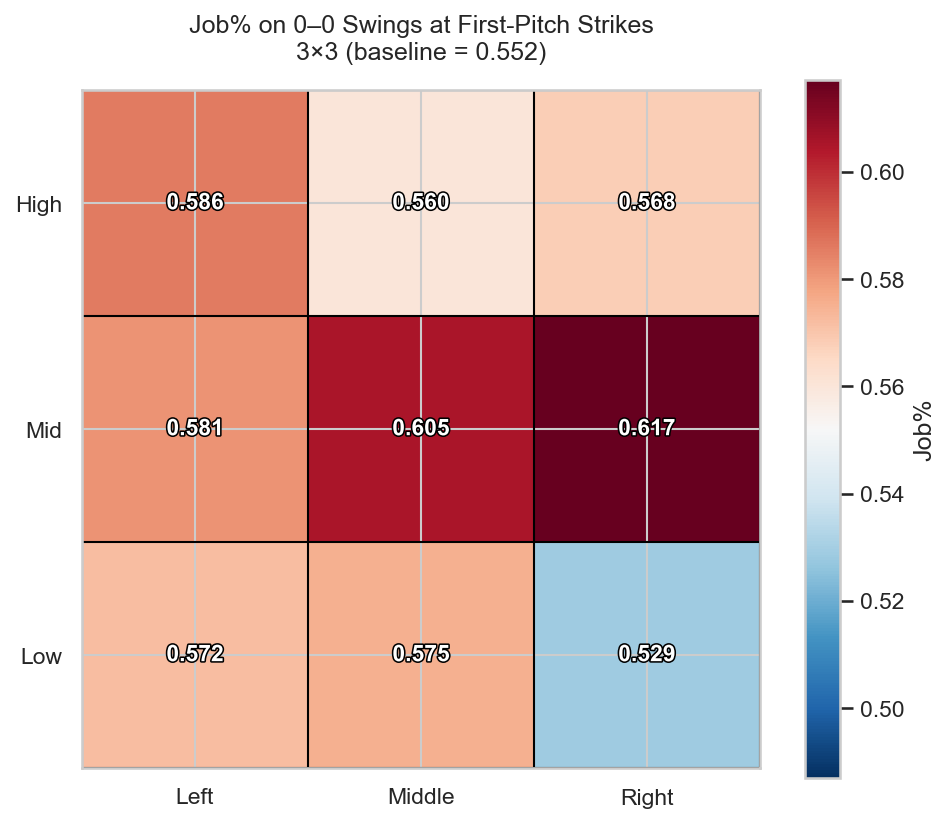

In [98]:
# --- Data ---
BASELINE = 0.552
vals = np.array([
    [0.586, 0.560, 0.568],
    [0.581, 0.605, 0.617],
    [0.572, 0.575, 0.529],
])
rows = ["High", "Mid", "Low"]
cols = ["Left", "Middle", "Right"]

# --- Centered colormap around baseline ---
diff = max(vals.max() - BASELINE, BASELINE - vals.min())
norm = TwoSlopeNorm(vmin=BASELINE - diff, vcenter=BASELINE, vmax=BASELINE + diff)

# --- Larger figure for visibility in Jupyter ---
fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=150)

# --- Heatmap ---
im = ax.imshow(vals, cmap="RdBu_r", norm=norm, origin="upper")

# --- Grid lines ---
for k in range(4):
    ax.axhline(k - 0.5, color="black", lw=1)
    ax.axvline(k - 0.5, color="black", lw=1)

# --- Value labels (white text + black outline for max visibility) ---
for r in range(vals.shape[0]):
    for c in range(vals.shape[1]):
        ax.text(c, r, f"{vals[r,c]:.3f}",
                ha="center", va="center",
                fontsize=11, fontweight="bold",
                color="white",
                path_effects=[pe.withStroke(linewidth=1.5, foreground='black')])

# --- Axis labels ---
ax.set_xticks(range(3), cols)
ax.set_yticks(range(3), rows)

# --- Title with padding ---
ax.set_title(f"Job% on 0–0 Swings at First-Pitch Strikes\n3×3 (baseline = {BASELINE:.3f})",
             pad=15)

# --- Axis limits ---
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(2.5, -0.5)

# --- Colorbar ---
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.06)
cb.set_label("Job%")

# --- Tight layout to avoid clipping ---
plt.tight_layout()
plt.show()


read in two strikes csv

In [99]:
two_strikes = pd.read_csv("2strikes.csv")

Get swing percentage on pitches in and out of the zone for different 2 strike counts

In [100]:
def ensure_swing_flag(df: pd.DataFrame) -> pd.DataFrame:
    if "swing_flag" in df.columns:
        df["swing_flag"] = df["swing_flag"].astype(bool)
        return df
    take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
    desc = df["description"].astype(str).str.lower()
    df["swing_flag"] = ~desc.isin(take_events)
    return df

def ensure_k_zone(df: pd.DataFrame) -> pd.DataFrame:
    if "k_zone" in df.columns:
        return df
    BR = 0.12
    for c in ["plate_x","plate_z","sz_bot","sz_top"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    in_x = df["plate_x"].abs() <= 0.83
    in_z = (df["plate_z"] + BR >= df["sz_bot"]) & (df["plate_z"] - BR <= df["sz_top"])
    df["k_zone"] = np.where(in_x & in_z, "Strike", "Ball")
    return df

def add_count_cols(df: pd.DataFrame) -> pd.DataFrame:
    cl = {c.lower(): c for c in df.columns}
    if "balls" in cl and "strikes" in cl:
        b = pd.to_numeric(df[cl["balls"]], errors="coerce").astype("Int64")
        s = pd.to_numeric(df[cl["strikes"]], errors="coerce").astype("Int64")
    elif "count" in cl:
        cnt = df[cl["count"]].astype(str)
        m = cnt.str.extract(r"(?P<b>\d)\s*[-–]\s*(?P<s>\d)")
        b = pd.to_numeric(m["b"], errors="coerce").astype("Int64")
        s = pda.to_numeric(m["s"], errors="coerce").astype("Int64")
    else:
        raise KeyError("Need 'balls' & 'strikes' or a 'count' column (e.g., '3-2').")
    df = df.assign(balls=b, strikes=s)
    df["count_str"] = df["balls"].astype(str) + "-" + df["strikes"].astype(str)
    return df

def swing_pivot(df: pd.DataFrame, by=None) -> pd.DataFrame:
    if by is None:
        df = df.assign(__grp="All")
        by = ["__grp"]
    g = (df.groupby(by + ["k_zone"])["swing_flag"]
           .agg(swung="sum", total="count")
           .reset_index())
    out = g.pivot(index=by, columns="k_zone", values=["swung","total"]).fillna(0).astype(int)
    for z in ["Strike","Ball"]:
        if ("swung", z) not in out.columns: out[("swung", z)] = 0
        if ("total", z) not in out.columns: out[("total", z)] = 0
    out[("pct","Strike")] = np.where(out[("total","Strike")] > 0, out[("swung","Strike")] / out[("total","Strike")], np.nan)
    out[("pct","Ball")]   = np.where(out[("total","Ball")]   > 0, out[("swung","Ball")]   / out[("total","Ball")],   np.nan)
    return out

def baseball_order(idx):
    bs = []
    for c in idx:
        try:
            b,s = c.split("-"); b,s = int(b), int(s)
        except Exception:
            b,s = 9,9
        bs.append((b,s,c))
    # keep only two-strike counts
    bs = [t for t in bs if 0 <= t[0] <= 3 and t[1] == 2]
    return [t[2] for t in sorted(bs, key=lambda x: (x[0], x[1]))]

# --- compute on two_strikes ---
df = two_strikes.copy()
df = ensure_swing_flag(df)
df = ensure_k_zone(df)
df = add_count_cols(df)
df = df.dropna(subset=["k_zone","swing_flag","balls","strikes"])

# (1) Overall two-strike swing% by zone
overall = swing_pivot(df, by=None)

# (2) By specific two-strike counts (0-2, 1-2, 2-2)
by_count = swing_pivot(df, by=["count_str"])
order = baseball_order(by_count.index)
by_count = by_count.loc[order]

# --- print results ---
# Overall
s_sw = overall.iloc[0][("swung","Strike")]; s_to = overall.iloc[0][("total","Strike")]; s_pc = overall.iloc[0][("pct","Strike")]
b_sw = overall.iloc[0][("swung","Ball")];   b_to = overall.iloc[0][("total","Ball")];   b_pc = overall.iloc[0][("pct","Ball")]
print("=== Two-Strike Overall — counts & swing% ===")
print(f"Strike {int(s_sw)}/{int(s_to)} ({'NA' if pd.isna(s_pc) else f'{s_pc*100:.1f}%'}), "
      f"Ball {int(b_sw)}/{int(b_to)} ({'NA' if pd.isna(b_pc) else f'{b_pc*100:.1f}%'})")

# By count
print("\n=== By Count (0-2, 1-2, 2-2) — counts & swing% ===")
for c in by_count.index:
    s_sw = by_count.loc[c, ("swung","Strike")]; s_to = by_count.loc[c, ("total","Strike")]; s_pc = by_count.loc[c, ("pct","Strike")]
    b_sw = by_count.loc[c, ("swung","Ball")];   b_to = by_count.loc[c, ("total","Ball")];   b_pc = by_count.loc[c, ("pct","Ball")]
    s_pct_str = "NA" if pd.isna(s_pc) else f"{s_pc*100:.1f}%"
    b_pct_str = "NA" if pd.isna(b_pc) else f"{b_pc*100:.1f}%"
    print(f"{c}:  Strike {int(s_sw)}/{int(s_to)} ({s_pct_str}) | Ball {int(b_sw)}/{int(b_to)} ({b_pct_str})")


=== Two-Strike Overall — counts & swing% ===
Strike 9609/10865 (88.4%), Ball 5279/14135 (37.3%)

=== By Count (0-2, 1-2, 2-2) — counts & swing% ===
0-2:  Strike 1591/1830 (86.9%) | Ball 1190/3791 (31.4%)
1-2:  Strike 2878/3239 (88.9%) | Ball 1854/5004 (37.1%)
2-2:  Strike 2944/3308 (89.0%) | Ball 1525/3672 (41.5%)
3-2:  Strike 2196/2488 (88.3%) | Ball 710/1668 (42.6%)


Graph first pitch and 2 strike swing and take metrics

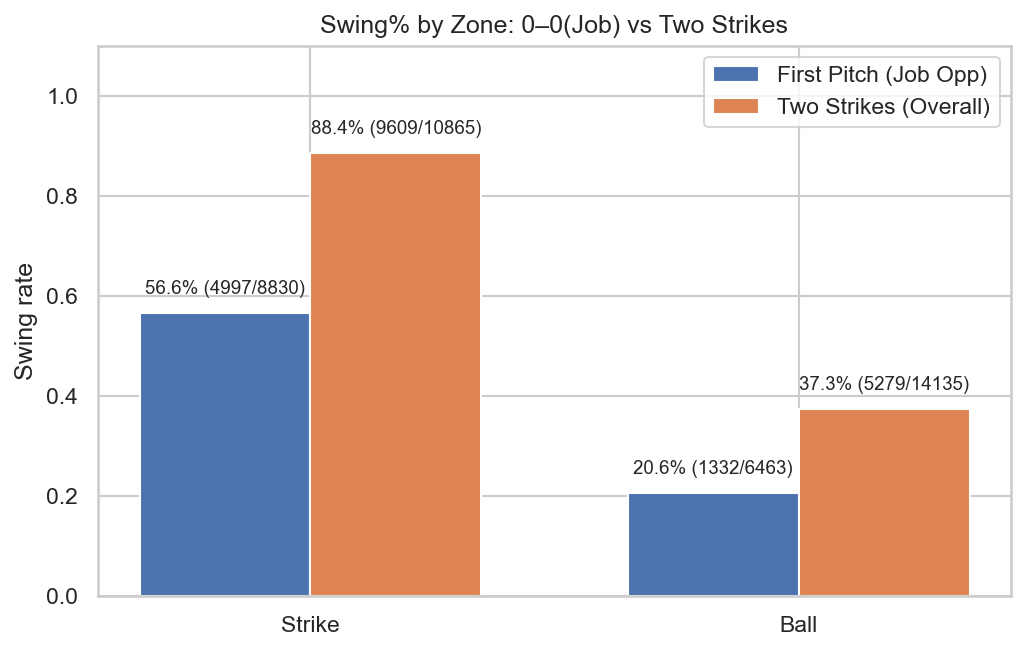

In [101]:
def ensure_swing_flag(df: pd.DataFrame) -> pd.DataFrame:
    if "swing_flag" in df.columns:
        df["swing_flag"] = df["swing_flag"].astype(bool)
        return df
    take_events = {"ball","called_strike","pitchout","blocked_ball","intent_ball","hit_by_pitch"}
    desc = df["description"].astype(str).str.lower()
    df["swing_flag"] = ~desc.isin(take_events)
    return df

def ensure_k_zone(df: pd.DataFrame) -> pd.DataFrame:
    if "k_zone" in df.columns:
        return df
    BR = 0.12
    for c in ["plate_x","plate_z","sz_bot","sz_top"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    in_x = df["plate_x"].abs() <= 0.83
    in_z = (df["plate_z"] + BR >= df["sz_bot"]) & (df["plate_z"] - BR <= df["sz_top"])
    df["k_zone"] = np.where(in_x & in_z, "Strike", "Ball")
    return df

def swing_table(df: pd.DataFrame) -> pd.DataFrame:
    g = (df.groupby("k_zone")["swing_flag"]
           .agg(swung="sum", total="count")
           .reindex(["Strike","Ball"])
           .fillna(0))
    g["swung"] = g["swung"].astype(int)
    g["total"] = g["total"].astype(int)
    g["pct"] = np.where(g["total"] > 0, g["swung"] / g["total"], np.nan)
    return g


dfc = combined.copy()
dfc = ensure_swing_flag(dfc)
dfc = ensure_k_zone(dfc)
dfc_fp = (dfc.sort_values(["game_pk","at_bat_number","pitch_number"])
            .drop_duplicates(["game_pk","at_bat_number"], keep="first")
            .dropna(subset=["k_zone","swing_flag"]))
tab_first = swing_table(dfc_fp)

ts = two_strikes.copy()
ts = ensure_swing_flag(ts)
ts = ensure_k_zone(ts)
ts = ts.dropna(subset=["k_zone","swing_flag"])
tab_2s = swing_table(ts)

# --- prep data for plot ---
zones = ["Strike","Ball"]

first_rates = tab_first.loc[zones, "pct"].to_numpy()
two_rates   = tab_2s.loc[zones, "pct"].to_numpy()

first_swung = tab_first.loc[zones, "swung"].to_numpy()
first_total = tab_first.loc[zones, "total"].to_numpy()
two_swung   = tab_2s.loc[zones, "swung"].to_numpy()
two_total   = tab_2s.loc[zones, "total"].to_numpy()

# --- plot (two series only) ---
x = np.arange(len(zones))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)
b1 = ax.bar(x - width/2, first_rates, width, label="First Pitch (Job Opp)")
b2 = ax.bar(x + width/2, two_rates,   width, label="Two Strikes (Overall)")

ax.set_title("Swing% by Zone: 0–0(Job) vs Two Strikes")
ax.set_ylabel("Swing rate")
ax.set_xticks(x, zones)
ax.set_ylim(0, 1.10)  # a bit more headroom for labels
ax.legend()

# annotate each bar with "xx.x% (swung/total)"
series = [
    (b1, first_rates, first_swung, first_total),
    (b2, two_rates,   two_swung,   two_total),
]

for bars, rates, swung_arr, total_arr in series:
    for j, b in enumerate(bars):
        h = rates[j]
        s = int(swung_arr[j]) if j < len(swung_arr) else 0
        t = int(total_arr[j]) if j < len(total_arr) else 0
        if np.isfinite(h) and t > 0:
            label = f"{h*100:.1f}% ({s}/{t})"
        else:
            label = "N/A"
        ax.text(b.get_x() + b.get_width()/2, (h if np.isfinite(h) else 0) + 0.03,
                label, ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


Run simulation of job percentage change and season wins added given 2 strike approach on first pitch of job opportuntity at bats

In [102]:
# Team-specific hypothetical: reallocate 0–0 decisions using each TEAM's own payoffs
# Output: 30 rows (one per team) with:
#  team, Attempts, Success (actual), Success_new (hypothetical), JobPct, JobPct_new, Delta_success
import numpy as np
import pandas as pd
import re

# ------- config -------
P_STRIKE_SWING = 0.884   # swing% on 0–0 strikes (from your two-strike study)
P_BALL_SWING   = 0.373   # swing% on 0–0 balls

SPEC_TOTAL       = "1) Total"
SPEC_STRIKE_SW   = "4) Swing 1st (zone=Strike)"
SPEC_BALL_SW     = "5) Swing 1st (zone=Ball)"
SPEC_STRIKE_TK   = "6) Take 1st (zone=Strike)"
SPEC_BALL_TK     = "7) Take 1st (zone=Ball)"
FOUR_SPECS = [SPEC_STRIKE_SW, SPEC_BALL_SW, SPEC_STRIKE_TK, SPEC_BALL_TK]

def _clean_cols(df):
    df = df.copy()
    df.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in df.columns]
    return df

def _pick(df, names):
    lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in lower:
            return lower[n.lower()]
    return None

# ------- attach input -------

t = _clean_cols(team_job_df)
c_team = _pick(t, ["team","Team","batting_team","club","org"])
c_spec = _pick(t, ["Spec","spec","Bucket","Label"])
c_succ = _pick(t, ["Success","succ"])
c_fail = _pick(t, ["Fail","failure","fails"])
c_att  = _pick(t, ["Attempts","attempts","Att"])
if not all([c_team, c_spec, c_succ, c_fail, c_att]):
    raise KeyError("team_job_df must have columns: team, Spec, Success, Fail, Attempts.")

t = t.rename(columns={c_team:"team", c_spec:"Spec", c_succ:"Success", c_fail:"Fail", c_att:"Attempts"})
t[["Success","Fail","Attempts"]] = t[["Success","Fail","Attempts"]].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# ------- league fallbacks per spec (in case a team has 0 attempts in a bucket) -------
league_totals = (t[t["Spec"].isin(FOUR_SPECS)]
                 .groupby("Spec")[["Success","Attempts"]].sum())
league_rates = (league_totals["Success"] / league_totals["Attempts"]).replace([np.inf, -np.inf], np.nan)

# ------- team-specific rates & attempts in the 4 buckets -------
four = t[t["Spec"].isin(FOUR_SPECS)].copy()
four["JobRate"] = np.where(four["Attempts"] > 0, four["Success"] / four["Attempts"], np.nan)

# attempts wide
A = four.pivot_table(index="team", columns="Spec", values="Attempts", aggfunc="sum").reindex(columns=FOUR_SPECS, fill_value=0)
# rates wide (fill missing with league)
R = four.pivot_table(index="team", columns="Spec", values="JobRate", aggfunc="mean").reindex(columns=FOUR_SPECS)
for spec in FOUR_SPECS:
    R[spec] = R[spec].fillna(league_rates.get(spec, np.nan))

# ensure teams with missing specs still appear
teams = sorted(t["team"].unique())
A = A.reindex(teams).fillna(0).astype(int)
R = R.reindex(teams)

# ------- current totals per team (from "1) Total") -------
totals = (t[t["Spec"].eq(SPEC_TOTAL)][["team","Success","Fail","Attempts"]]
          .drop_duplicates()
          .set_index("team"))
# fallback if "1) Total" missing: sum across all specs for that team
missing = set(teams) - set(totals.index)
if missing:
    fb = (t.groupby("team")[["Success","Fail","Attempts"]].sum())
    totals = pd.concat([totals, fb.loc[list(missing)]], axis=0)

# ------- reallocate decisions under new approach (attempts stay the same) -------
N_strike = (A[SPEC_STRIKE_SW] + A[SPEC_STRIKE_TK]).astype(int)
N_ball   = (A[SPEC_BALL_SW]   + A[SPEC_BALL_TK]).astype(int)

S_strike_new = np.rint(N_strike * P_STRIKE_SWING).astype(int)
T_strike_new = N_strike - S_strike_new
S_ball_new   = np.rint(N_ball   * P_BALL_SWING).astype(int)
T_ball_new   = N_ball   - S_ball_new

# ------- expected successes using TEAM-SPECIFIC payoffs -------
succ_new = (
    S_strike_new * R[SPEC_STRIKE_SW] +
    T_strike_new * R[SPEC_STRIKE_TK] +
    S_ball_new   * R[SPEC_BALL_SW]   +
    T_ball_new   * R[SPEC_BALL_TK]
).round().astype(int)  # round to nearest whole success

# ------- assemble comparison table -------
out = pd.DataFrame({
    "Team": teams,
    "Attempts": totals.loc[teams, "Attempts"].values,
    "Success":  totals.loc[teams, "Success"].values,
    "Success_new": succ_new.reindex(teams).fillna(0).astype(int).values
})
out["JobPct"]     = np.where(out["Attempts"]>0, out["Success"]     / out["Attempts"], np.nan)
out["JobPct_new"] = np.where(out["Attempts"]>0, out["Success_new"] / out["Attempts"], np.nan)
out["Delta_success"] = out["Success_new"] - out["Success"]

# order & (optional) pretty %
out = out.sort_values("Delta_success", ascending=False).reset_index(drop=True)

if 'out' in globals():
    df = out.copy()
elif 'team_job_compare' in globals():
    df = team_job_compare.copy()
else:
    raise NameError("Couldn't find the comparison DataFrame (`out` or `team_job_compare`).")

# ensure JobPct columns exist (as proportions 0..1)
if "JobPct" not in df.columns or "JobPct_new" not in df.columns:
    if {"Success","Success_new","Attempts"}.issubset(df.columns):
        df["JobPct"]     = np.where(df["Attempts"]>0, df["Success"]     / df["Attempts"], np.nan)
        df["JobPct_new"] = np.where(df["Attempts"]>0, df["Success_new"] / df["Attempts"], np.nan)
    else:
        raise KeyError("Need JobPct/JobPct_new or (Success, Success_new, Attempts) to compute them.")

# regression coefficient for job_pct (wins per +1.00 = +100pp)
JOB_COEF = 14.7541

df["Season Wins Added"] = JOB_COEF * (df["JobPct_new"] - df["JobPct"])
df["Season Wins Added"] = df["Season Wins Added"].round(2)

# (optional) sort by wins added
df = df.sort_values("Season Wins Added", ascending=False).reset_index(drop=True)
df.index = df.index + 1

df

,Team,Attempts,Success,Success_new,JobPct,JobPct_new,Delta_success,Season Wins Added
1,PHI,476,283,296,0.594538,0.621849,13,0.40
2,PIT,443,243,254,0.548533,0.573363,11,0.37
3,HOU,409,210,219,0.513447,0.535452,9,0.32
4,LAA,378,189,196,0.500000,0.518519,7,0.27
5,WSH,466,258,266,0.553648,0.570815,8,0.25
6,BOS,523,265,273,0.506692,0.521989,8,0.23
7,SD,471,275,282,0.583864,0.598726,7,0.22
8,KC,428,245,251,0.572430,0.586449,6,0.21
9,CIN,492,272,278,0.552846,0.565041,6,0.18
10,CWS,444,233,238,0.524775,0.536036,5,0.17


Get stats of batted balls in 2 strike counts

In [103]:
pd.set_option("display.width", 200)       # widen display
pd.set_option("display.max_columns", 20)  # show all columns

# --- 1. Filter for balls hit in play ---
in_play = two_strikes[two_strikes["description"] == "hit_into_play"].copy()

# --- 2. Basic stats ---
PA = len(in_play)
AB = PA
H = in_play["events"].isin(["single", "double", "triple", "home_run"]).sum()
BB = in_play["events"].eq("walk").sum()
HBP = in_play["events"].eq("hit_by_pitch").sum()
SF = in_play["events"].eq("sac_fly").sum()
TB = in_play["events"].map({
    "single": 1,
    "double": 2,
    "triple": 3,
    "home_run": 4
}).fillna(0).sum()

# --- 3. Rate stats ---
OBP = (H + BB + HBP) / (AB + BB + HBP + SF) if (AB + BB + HBP + SF) > 0 else np.nan
SLG = TB / AB if AB > 0 else np.nan
OPS = OBP + SLG if pd.notna(OBP) and pd.notna(SLG) else np.nan

# --- 4. Output nicely ---
summary = pd.DataFrame([{
    "Spec": "Balls hit into play(2 Strikes)",
    "AB": AB,
    "OBP": round(OBP, 3),
    "SLG": round(SLG, 3),
    "OPS": round(OPS, 3)
}])


summary


,Spec,AB,OBP,SLG,OPS
0,Balls hit into play(2 Strikes),5392,0.308,0.514,0.823


Read in playoff data set

In [104]:
playoffs = pd.read_csv("playoffs.csv")

Sort playoff data set

In [105]:
# Make a copy (optional but safe)
playoffs_sorted = playoffs.copy()

# 1) Convert columns to proper types for sorting
playoffs_sorted["game_date"] = pd.to_datetime(playoffs_sorted["game_date"], errors="coerce")
playoffs_sorted["game_pk"] = pd.to_numeric(playoffs_sorted["game_pk"], errors="coerce")
playoffs_sorted["at_bat_number"] = pd.to_numeric(playoffs_sorted["at_bat_number"], errors="coerce")

# 2) Sort properly:
#    Earliest date → game → at-bat order
playoffs_sorted = playoffs_sorted.sort_values(
    by=["game_date", "game_pk", "at_bat_number"],
    ascending=[True, True, True],
    kind="mergesort"  # stable sort = preserves correct internal order
).reset_index(drop=True)

playoffs_sorted


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2022-10-07,94.5,-3.14,5.66,"Profar, Jurickson",595777,453286,single,hit_into_play,...,1.0,1.15,1.23,-1.23,29.3,NaN,NaN,NaN,NaN,NaN
1,FC,2022-10-07,89.2,-3.15,5.39,"Soto, Juan",665742,453286,strikeout,swinging_strike,...,1.0,2.11,-0.12,0.12,24.3,NaN,NaN,NaN,NaN,NaN
2,SL,2022-10-07,85.4,-3.19,5.48,"Machado, Manny",592518,453286,field_out,hit_into_play,...,1.0,2.92,-0.55,-0.55,26.6,NaN,NaN,NaN,NaN,NaN
3,FF,2022-10-07,95.4,-3.03,5.63,"Bell, Josh",605137,453286,home_run,hit_into_play,...,1.0,1.18,0.74,-0.74,33.0,NaN,NaN,NaN,NaN,NaN
4,CH,2022-10-07,84.9,-3.28,5.42,"Cronenworth, Jake",630105,453286,strikeout,swinging_strike,...,1.0,2.74,1.20,-1.20,27.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9292,CU,2024-10-30,75.5,-1.14,6.05,"Edman, Tommy",669242,643410,strikeout,swinging_strike,...,NaN,5.52,-0.60,0.60,54.4,23.232530,-38.572875,31.194750,31.515521,57.721184
9293,ST,2024-10-30,79.4,-1.48,5.81,"Smith, Will",669257,643410,field_out,hit_into_play,...,NaN,4.20,-0.91,-0.91,45.7,NaN,NaN,NaN,NaN,NaN
9294,KC,2024-10-30,77.6,-1.08,5.75,"Volpe, Anthony",683011,621111,field_out,hit_into_play,...,NaN,5.33,-1.08,-1.08,53.9,16.663536,-14.289227,22.537581,37.696324,36.717750
9295,KC,2024-10-30,77.4,-1.23,5.78,"Wells, Austin",669224,621111,strikeout,swinging_strike,...,NaN,5.20,-1.08,1.08,50.0,22.643800,-12.035832,32.683497,40.578398,40.302028


Add job opportunity column

In [106]:
# Make a copy to be safe (optional)
playoffs_sorted = playoffs_sorted.copy()

# Convert outs column just to be sure it's numeric
playoffs_sorted["outs_when_up"] = pd.to_numeric(playoffs_sorted["outs_when_up"], errors="coerce")

# Create boolean flags for base states
runner_on_3rd = playoffs_sorted["on_3b"].notna()
runner_on_2nd = playoffs_sorted["on_2b"].notna()

# Apply the job opportunity definition
playoffs_sorted["job_opportunity"] = (
    ((runner_on_3rd) & (playoffs_sorted["outs_when_up"].isin([0, 1])))
    |
    ((runner_on_2nd) & (playoffs_sorted["outs_when_up"] == 0))
)


Add success/fail column

In [107]:
import numpy as np
import pandas as pd

# Work on a copy (optional)
playoffs_sorted = playoffs_sorted.copy()

# Ensure needed types
playoffs_sorted["game_date"] = pd.to_datetime(playoffs_sorted["game_date"], errors="coerce")
playoffs_sorted["game_pk"] = pd.to_numeric(playoffs_sorted["game_pk"], errors="coerce")
playoffs_sorted["at_bat_number"] = pd.to_numeric(playoffs_sorted["at_bat_number"], errors="coerce")
playoffs_sorted["outs_when_up"] = pd.to_numeric(playoffs_sorted["outs_when_up"], errors="coerce")

# Helper flags for job eligibility (your official spec)
r3_job = playoffs_sorted["on_3b"].notna() & playoffs_sorted["outs_when_up"].isin([0, 1])
r2_job = playoffs_sorted["on_2b"].notna() & (playoffs_sorted["outs_when_up"] == 0) & (~r3_job)  # 3B takes precedence
playoffs_sorted["job_opportunity"] = r3_job | r2_job  # in case it's not already present

# We need the "next AB in the same half-inning" to infer outs after this AB.
# Same half-inning grouping key:
grp_keys = ["game_pk", "inning", "inning_topbot"]

# Next-row fields within same half-inning
playoffs_sorted = playoffs_sorted.sort_values(
    by=["game_date", "game_pk", "at_bat_number"],
    kind="mergesort"
).reset_index(drop=True)

# Compute next AB context within same half-inning (shift -1 per group)
for col in ["outs_when_up", "on_2b", "on_3b"]:
    playoffs_sorted[f"next_{col}"] = (
        playoffs_sorted.groupby(grp_keys, sort=False)[col].shift(-1)
    )

# If there is no next AB in this half-inning, the inning ended -> outs_after = 3
same_half_has_next = playoffs_sorted.groupby(grp_keys)["at_bat_number"].shift(-1).notna()

outs_before = playoffs_sorted["outs_when_up"]
outs_after = np.where(
    same_half_has_next,
    playoffs_sorted["next_outs_when_up"],
    3  # inning ended; outs after must be 3
)

# Outs recorded on this AB (floor at 0)
outs_recorded = np.maximum((outs_after - outs_before).fillna(0), 0)
playoffs_sorted["outs_recorded"] = outs_recorded

# Runs scored by the batting team on this AB
# (Statcast convention: use batting team score deltas on the row)
runs_scored = (playoffs_sorted["post_bat_score"] - playoffs_sorted["bat_score"]).fillna(0)
playoffs_sorted["runs_scored_bat"] = runs_scored

# Did runner from 3rd score?  -> proxy: any run for batting team on this AB
r3_success = runs_scored.gt(0)

# Did runner from 2nd reach 3rd (or score) with <=1 out after?
# We detect "runner reached 3rd" via next on_3b at start of the next AB in SAME half-inning,
# and we treat scoring as success (cannot track individual runner IDs with given columns).
runner_on_3rd_after = (
    same_half_has_next & playoffs_sorted["next_on_3b"].notna()
)

# Success condition for R2 job:
#   - (reached 3rd AFTER) OR (scored)
#   - AND outs_after <= 1 (i.e., still 0 or 1 out after the AB)
r2_success = (runner_on_3rd_after | runs_scored.gt(0)) & (outs_after <= 1)

# Fail / Neutral logic per your rules:

# Runner on 3rd jobs:
#   Success: runs_scored > 0
#   Fail:    outs_recorded > 0 AND runs_scored == 0
#   Neutral: outs_recorded == 0 AND runs_scored == 0
r3_fail    = outs_recorded.gt(0) & runs_scored.eq(0)
r3_neutral = outs_recorded.eq(0) & runs_scored.eq(0)

# Runner on 2nd jobs (0 outs only by spec):
#   Success: (to 3rd OR scored) AND outs_after <= 1
#   Fail:    outs_recorded > 0 AND NOT success
#   Neutral: outs_recorded == 0 AND NOT success
r2_fail    = outs_recorded.gt(0) & (~r2_success)
r2_neutral = outs_recorded.eq(0) & (~r2_success)

# Initialize job_result as NA
job_result = pd.Series(pd.NA, index=playoffs_sorted.index, dtype="string")

# Assign 3B jobs first (precedence)
job_result = job_result.mask(r3_job & r3_success, "Success")
job_result = job_result.mask(r3_job & r3_fail,    "Fail")
job_result = job_result.mask(r3_job & r3_neutral, "Neutral")

# Assign 2B jobs where 3B job is not active
job_result = job_result.mask(r2_job & r2_success, "Success")
job_result = job_result.mask(r2_job & r2_fail,    "Fail")
job_result = job_result.mask(r2_job & r2_neutral, "Neutral")

# Leave non-job rows as <NA> (or set to "Non-Job" if you prefer)
playoffs_sorted["job_result"] = job_result

# Optional sanity checks:
# 1) Ensure all job_opportunity rows received a label
# print(playoffs_sorted.loc[playoffs_sorted["job_opportunity"] & playoffs_sorted["job_result"].isna(),
#                           ["game_pk","inning","inning_topbot","at_bat_number","outs_when_up",
#                            "bat_score","post_bat_score"]].head())


Add batting team column

In [108]:
playoffs_sorted = playoffs_sorted.copy()

# Standardize the inning_topbot column just in case
playoffs_sorted["inning_topbot"] = playoffs_sorted["inning_topbot"].str.lower()

# Create batting_team
playoffs_sorted["batting_team"] = np.where(
    playoffs_sorted["inning_topbot"].str.startswith("top"),
    playoffs_sorted["away_team"],
    playoffs_sorted["home_team"]
)


Run game level regression on the effect of job opportunity for playoff games

In [109]:
df = playoffs_sorted.copy()
df["game_pk"] = pd.to_numeric(df["game_pk"], errors="coerce")
df["at_bat_number"] = pd.to_numeric(df["at_bat_number"], errors="coerce")
df = df.sort_values(["game_date","game_pk","at_bat_number"], kind="mergesort").reset_index(drop=True)

# ---------- 1) Final score per game ----------
# Take the last AB in each game to read final score
final_scores = (
    df.groupby("game_pk", as_index=False)
      .tail(1)[["game_pk","home_team","away_team","post_home_score","post_away_score"]]
      .rename(columns={"post_home_score":"final_home","post_away_score":"final_away"})
)

# ---------- 2) Game-level JOB% per team (job opps only; ignore Neutral) ----------
job_rows = df[(df["job_opportunity"] == True) & (df["job_result"].isin(["Success","Fail"]))]

job_game = (
    job_rows.groupby(["game_pk","batting_team"])["job_result"]
            .value_counts()
            .unstack(fill_value=0)[["Success","Fail"]]
            .assign(
                opps=lambda d: d["Success"] + d["Fail"],
                job_pct=lambda d: np.where(d["opps"]>0, d["Success"]/d["opps"], np.nan)
            )
            .reset_index()
)

# ---------- 3) OBP_game & SLG_game from ALL ABs for that batting team in that game ----------
# Derive components from Statcast 'events'
events = df.copy()
ev = events["events"].astype(str).str.lower()

hit_events = {"single","double","triple","home_run"}
bb_events  = {"walk","intent_walk"}
hbp_events = {"hit_by_pitch"}
sf_events  = {"sac_fly","sac_fly_double_play"}
sh_events  = {"sac_bunt","sac_bunt_double_play"}
no_ab_events = bb_events | hbp_events | sf_events | sh_events | {"catcher_interference","catcher_interf"}

events["H"]   = ev.isin(hit_events).astype(int)
events["BB"]  = ev.isin(bb_events).astype(int)
events["HBP"] = ev.isin(hbp_events).astype(int)
events["SF"]  = ev.isin(sf_events).astype(int)
events["SH"]  = ev.isin(sh_events).astype(int)
# AB credited for most outs/balls in play that are not in no-AB set
events["AB"]  = (~ev.isin(no_ab_events)).astype(int)

# Total bases
tb_map = {"single":1,"double":2,"triple":3,"home_run":4}
events["TB"] = ev.map(tb_map).fillna(0).astype(int)

# Aggregate by team-game
bat_game = (
    events.groupby(["game_pk","batting_team"], as_index=False)
          .agg(H=("H","sum"), BB=("BB","sum"), HBP=("HBP","sum"), AB=("AB","sum"), SF=("SF","sum"), TB=("TB","sum"))
)

# OBP = (H + BB + HBP) / (AB + BB + HBP + SF)
# SLG = TB / AB
bat_game["PA_for_OBP"] = bat_game["AB"] + bat_game["BB"] + bat_game["HBP"] + bat_game["SF"]
bat_game["OBP_game"] = np.where(bat_game["PA_for_OBP"]>0,
                                (bat_game["H"] + bat_game["BB"] + bat_game["HBP"]) / bat_game["PA_for_OBP"],
                                np.nan)
bat_game["SLG_game"] = np.where(bat_game["AB"]>0, bat_game["TB"] / bat_game["AB"], np.nan)

# ---------- 4) Merge scores & compute is_home, runs_allowed, win ----------
# First, attach home/away labels for each team-game
teams = df[["game_pk","home_team","away_team"]].drop_duplicates()

game_team = (
    bat_game.merge(teams, on="game_pk", how="left")
            .merge(final_scores, on=["game_pk","home_team","away_team"], how="left")
)

game_team["is_home"] = (game_team["batting_team"] == game_team["home_team"]).astype(int)

# runs_allowed is opponent's final runs
game_team["runs_allowed"] = np.where(game_team["is_home"]==1, game_team["final_away"], game_team["final_home"])

# team final runs (for win flag)
game_team["runs_scored"] = np.where(game_team["is_home"]==1, game_team["final_home"], game_team["final_away"])
game_team["win"] = (game_team["runs_scored"] > game_team["runs_allowed"]).astype(int)

# ---------- 5) Add game Job% (merge) ----------
game_team = game_team.merge(job_game[["game_pk","batting_team","job_pct"]],
                            on=["game_pk","batting_team"], how="left")

# Optional: drop games with no job opps (job_pct NaN) or keep them as missing
# Common approach: drop rows with any NaNs needed for regression
reg_df = game_team[["win","job_pct","OBP_game","SLG_game","runs_allowed","is_home"]].dropna().reset_index(drop=True)

# ---------- 6) Run OLS ----------
import statsmodels.api as sm
X = reg_df[["job_pct","OBP_game","SLG_game","runs_allowed","is_home"]]
X = sm.add_constant(X)
y = reg_df["win"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     57.91
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           6.30e-37
Time:                        16:07:05   Log-Likelihood:                -55.901
No. Observations:                 204   AIC:                             123.8
Df Residuals:                     198   BIC:                             143.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0245      0.108     -0.226   